In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score

In [2]:
# Import 30min results dataframes
df30min1 = pd.read_csv('../Modelling/30MIN_GRID_LSTM/RUN(1)_30MIN_close.csv')
df30min2 = pd.read_csv('../Modelling/30MIN_GRID_LSTM/RUN(2)_30MIN_close.csv')
df30min3 = pd.read_csv('../Modelling/30MIN_GRID_LSTM/RUN(3)_30MIN_close_diff.csv')
df30min4 = pd.read_csv('../Modelling/30MIN_GRID_LSTM/RUN(4)_30MIN_close_diff.csv')

# Import 4h results dataframes
df4h1 = pd.read_csv('../Modelling/4H_GRID_LSTM/RUN1_4H_close.csv')
df4h2 = pd.read_csv('../Modelling/4H_GRID_LSTM/RUN2_4H_close.csv')
df4h3 = pd.read_csv('../Modelling/4H_GRID_LSTM/RUN3_4H_close_diff.csv')
df4h4 = pd.read_csv('../Modelling/4H_GRID_LSTM/RUN4_4H_close_diff.csv')

# Import 1d results dataframes
df1d1 = pd.read_csv('../Modelling/1D_GRID_LSTM/RUN1_DAILY_close.csv')
df1d2 = pd.read_csv('../Modelling/1D_GRID_LSTM/RUN2_DAILY_close.csv')
df1d3 = pd.read_csv('../Modelling/1D_GRID_LSTM/RUN3_DAILY_close_diff.csv')
df1d4 = pd.read_csv('../Modelling/1D_GRID_LSTM/RUN4_DAILY_close_diff.csv')

# Create dataframe lists
dfs_30min = [df30min1, df30min2, df30min3, df30min4]
dfs_4h = [df4h1, df4h2, df4h3, df4h4]
dfs_1d = [df1d1, df1d2, df1d3, df1d4]
all_dfs = dfs_30min + dfs_4h + dfs_1d

# Create lists to filter by target
close_dfs = [df30min1, df30min2, df4h1, df4h2, df1d1, df1d2]
close_diff_dfs = [df30min3, df30min4, df4h3, df4h4, df1d3, df1d4]

# Create lists to filter by feature set
price_only_dfs = [df30min1, df30min3, df4h1, df4h3, df1d1, df1d3]
full_feature_dfs = [df30min2, df30min4, df4h2, df4h4, df1d2, df1d4]


# Add 'time_frame' and 'target' columns
for df in dfs_30min:
    df['time_frame'] = '30min'
for df in dfs_4h:
    df['time_frame'] = '4h'
for df in dfs_1d:
    df['time_frame'] = '1d'
for df in close_dfs:
    df['target'] = 'close'
for df in close_diff_dfs:
    df['target'] = 'close_diff'
for df in price_only_dfs:
    df['features'] = 'price_only'
for df in full_feature_dfs:
    df['features'] = 'price_plus_diffs'

# Concatenate all dataframes
combined_df = pd.concat(all_dfs)

# Remove columns with only one unique value
columns_to_drop = [column for column in combined_df.columns if combined_df[column].nunique() == 1]
combined_df = combined_df.drop(columns=columns_to_drop)

print(f"Dropped columns: {columns_to_drop}\n")
print(f"Remaining columns: {combined_df.columns.tolist()}")
# Create lists for features and metrics of interest 
features_of_interest = [
    'window_size',
    'lstm_dim',
    'dense_dim',
    'batch_size',
    'num_epochs'
]

metrics_of_interest = [
    'test_mae',
    'test_directional_acc'
]

features_of_interest2 = [
    
]


# Create filtered dataframes 
combined_close = combined_df[combined_df['target'] == 'close']
combined_close_diff = combined_df[combined_df['target'] == 'close_diff']
combined_30min = combined_df[combined_df['time_frame'] == '30min']
combined_4h = combined_df[combined_df['time_frame'] == '4h']
combined_1d = combined_df[combined_df['time_frame'] == '1d']


Dropped columns: ['num_layers', 'dropout', 'lr', 'optimizer_type', 'patience', 'activation_function']

Remaining columns: ['window_size', 'lstm_dim', 'dense_dim', 'batch_size', 'num_epochs', 'train_mse', 'test_mse', 'train_mae', 'test_mae', 'train_rmse', 'test_rmse', 'train_r2', 'test_r2', 'train_mape', 'test_mape', 'train_directional_acc', 'test_directional_acc', 'training_time', 'evaluation_time', 'time_frame', 'target', 'features']


In [23]:
combined_df.features

0           price_only
1           price_only
2           price_only
3           price_only
4           price_only
            ...       
22    price_plus_diffs
23    price_plus_diffs
24    price_plus_diffs
25    price_plus_diffs
26    price_plus_diffs
Name: features, Length: 594, dtype: object

In [3]:
# Create function for filtering dataframes by top n 'test_mae'
def filter_top_n_by_test_mae(df, n=10, ascending=True):
    """
    Filters the DataFrame to return the top N rows based on the 'test_mae' column.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame to filter.
    - n (int): The number of top rows to return. Default is 10.
    - ascending (bool): If True, return the smallest N values. If False, return the largest N values. Default is False.
    
    Returns:
    - pd.DataFrame: A DataFrame containing the top N rows based on 'test_mae'.
    """
    if ascending:
        return df.nsmallest(n, 'test_mae')
    else:
        return df.nlargest(n, 'test_mae')

In [4]:
# Create top10 dataframes
df_30min_top10 = filter_top_n_by_test_mae(combined_30min, n=10)
df_4h_top10 = filter_top_n_by_test_mae(combined_4h, n=10)
df_1d_top10 = filter_top_n_by_test_mae(combined_1d, n=10)

# Create top20 dataframes
df_30min_top20 = filter_top_n_by_test_mae(combined_30min, n=20)
df_4h_top20 = filter_top_n_by_test_mae(combined_4h, n=20)
df_1d_top20 = filter_top_n_by_test_mae(combined_1d, n=20)

In [7]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 594 entries, 0 to 26
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   window_size            594 non-null    int64  
 1   lstm_dim               594 non-null    int64  
 2   dense_dim              594 non-null    int64  
 3   batch_size             594 non-null    int64  
 4   num_epochs             594 non-null    int64  
 5   train_mse              594 non-null    float64
 6   test_mse               594 non-null    float64
 7   train_mae              594 non-null    float64
 8   test_mae               594 non-null    float64
 9   train_rmse             594 non-null    float64
 10  test_rmse              594 non-null    float64
 11  train_r2               594 non-null    float64
 12  test_r2                594 non-null    float64
 13  train_mape             594 non-null    float64
 14  test_mape              594 non-null    float64
 15  train_direct

In [8]:
def compare_mae_close_vs_diff(df):
    comparison = df.groupby(['time_frame', 'target'])['test_mae'].agg(['mean', 'min', 'max'])
    return comparison

mae_comparison = compare_mae_close_vs_diff(combined_df)
print(mae_comparison)

                             mean         min         max
time_frame target                                        
1d         close       251.656423  221.395200  341.046526
           close_diff  253.871547  233.042952  293.749895
30min      close        39.189481   29.676017   91.810358
           close_diff   30.139300   29.063402   35.445820
4h         close       115.947497   86.662835  223.852877
           close_diff   99.660096   84.858369  128.901484


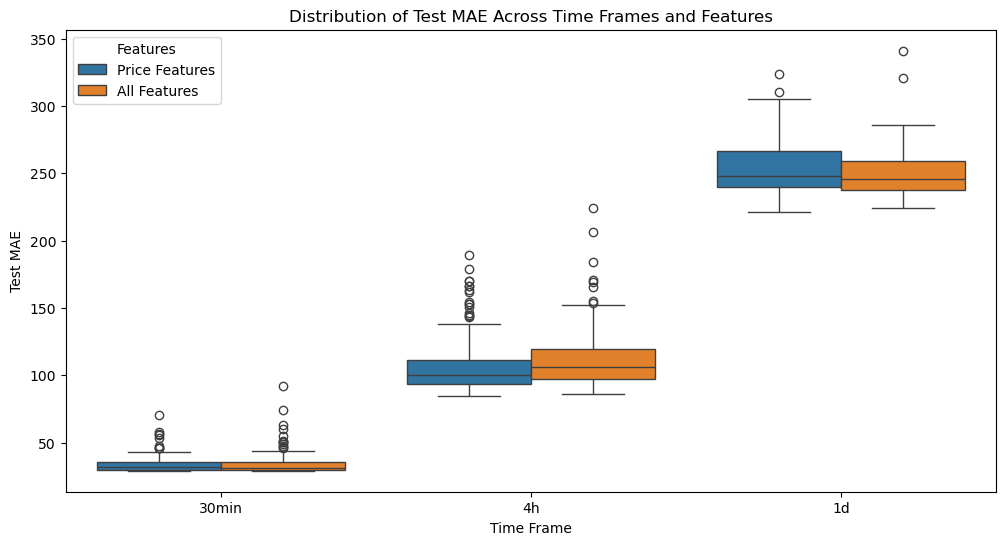

In [9]:
# Define the function to plot the MAE distribution
def plot_mae_distribution(df, hue='target', custom_labels=None, legend_title='Legend'):
    plt.figure(figsize=(12, 6))
    box_plot = sns.boxplot(x='time_frame', y='test_mae', hue=hue, data=df)
    plt.title('Distribution of Test MAE Across Time Frames and Features')
    plt.xlabel('Time Frame')
    plt.ylabel('Test MAE')
    plt.xticks(rotation=0)
    
    # Modify the legend labels and title if custom_labels is provided
    if custom_labels:
        handles, _ = box_plot.get_legend_handles_labels()
        box_plot.legend(handles=handles, labels=custom_labels, title=legend_title)
    
    plt.show()


custom_labels = ['Price Features', 'All Features']
plot_mae_distribution(combined_df, hue='features', custom_labels=custom_labels, legend_title='Features')

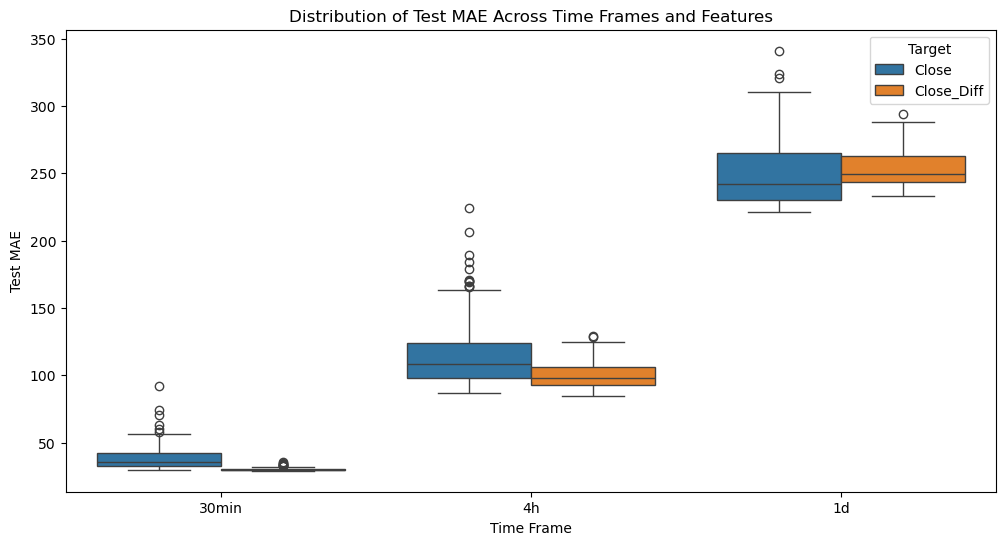

In [10]:
custom_labels = ['Close', 'Close_Diff']
plot_mae_distribution(combined_df, hue='target', custom_labels=custom_labels, legend_title='Target')

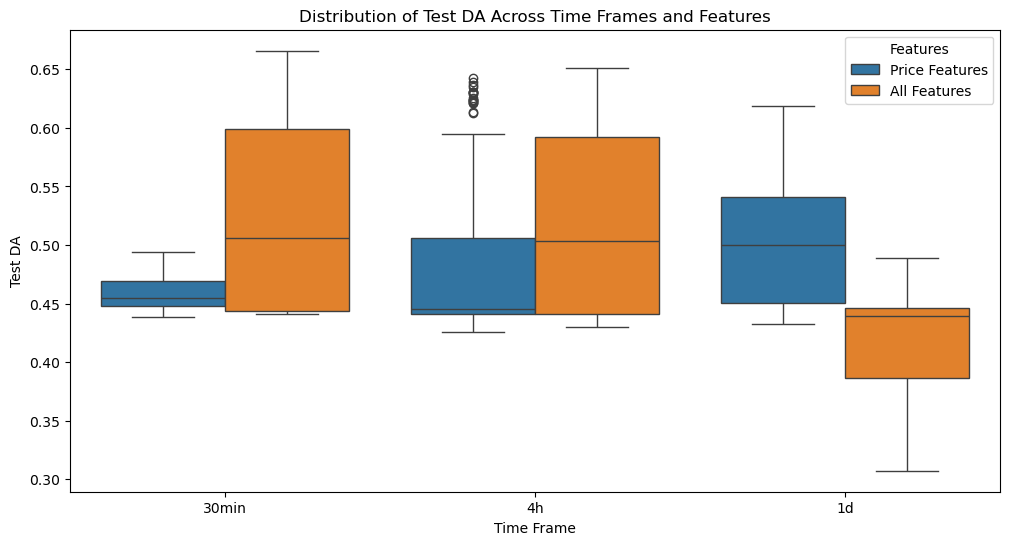

In [14]:
# Define the function to plot the MAE distribution
def plot_da_distribution(df, hue='target', custom_labels=None, legend_title='Legend'):
    plt.figure(figsize=(12, 6))
    box_plot = sns.boxplot(x='time_frame', y='test_directional_acc', hue=hue, data=df)
    plt.title('Distribution of Test DA Across Time Frames and Features')
    plt.xlabel('Time Frame')
    plt.ylabel('Test DA')
    plt.xticks(rotation=0)
    
    # Modify the legend labels and title if custom_labels is provided
    if custom_labels:
        handles, _ = box_plot.get_legend_handles_labels()
        box_plot.legend(handles=handles, labels=custom_labels, title=legend_title)
    
    plt.show()


custom_labels = ['Price Features', 'All Features']
plot_da_distribution(combined_df, hue='features', custom_labels=custom_labels, legend_title='Features')

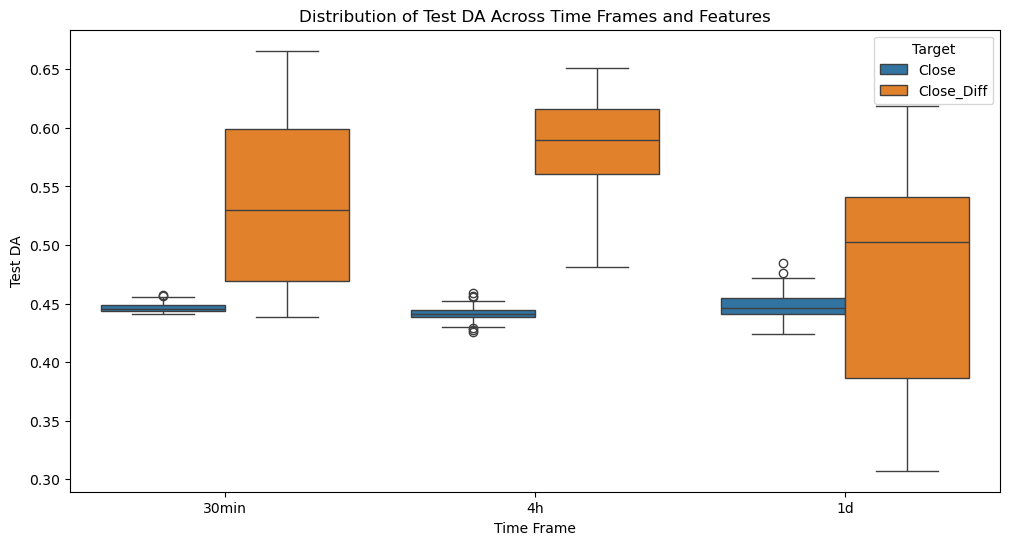

In [16]:
custom_labels = ['Close', 'Close_Diff']
plot_da_distribution(combined_df, hue='target', custom_labels=custom_labels, legend_title='Target')

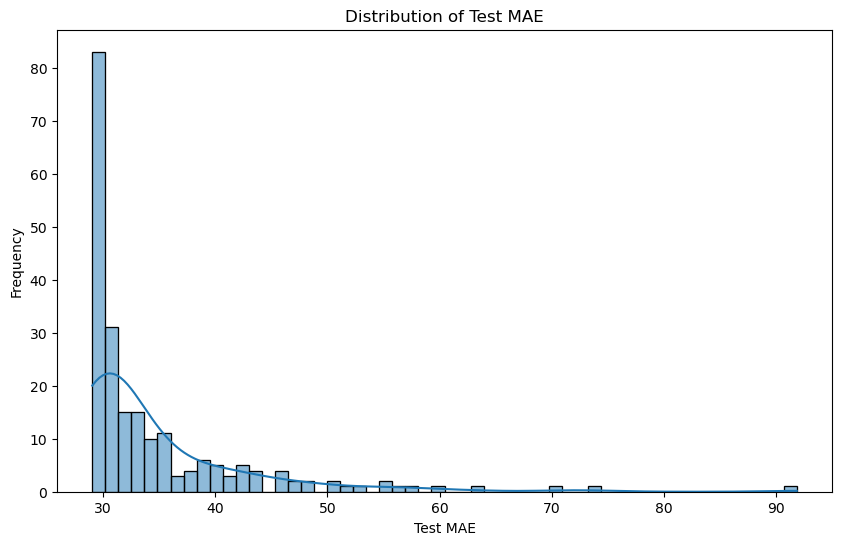

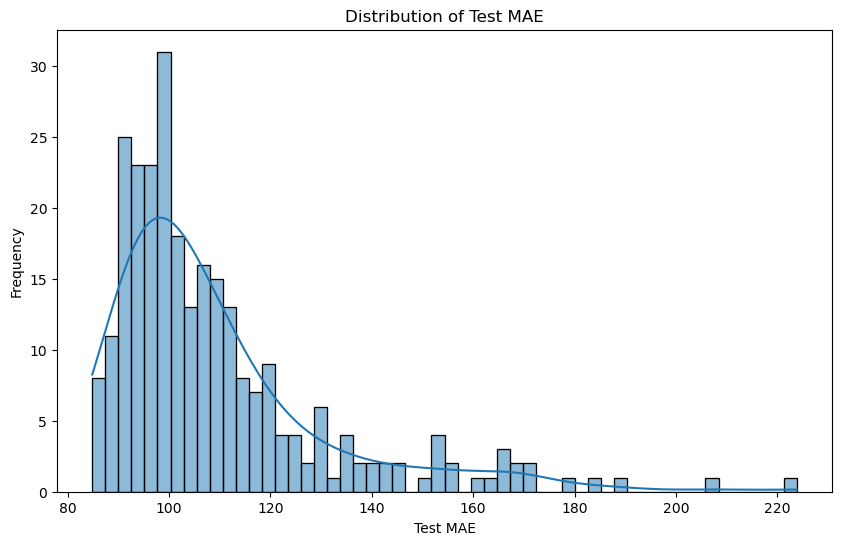

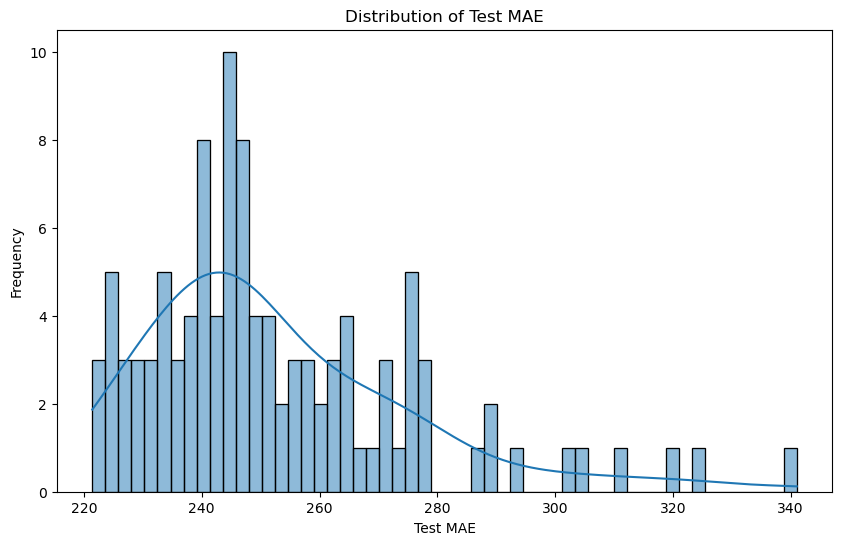

In [11]:
# Plot the distribution of test_mae

def plot_mae_histogram(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df['test_mae'], kde=True, bins=54)
    plt.title('Distribution of Test MAE')
    plt.xlabel('Test MAE')
    plt.ylabel('Frequency')
    plt.show()

plot_mae_histogram(combined_30min)
plot_mae_histogram(combined_4h)
plot_mae_histogram(combined_1d)


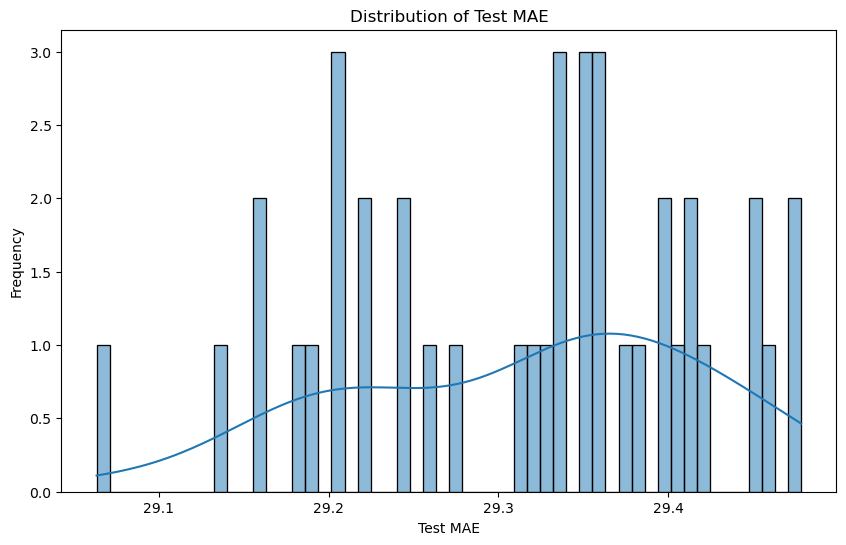

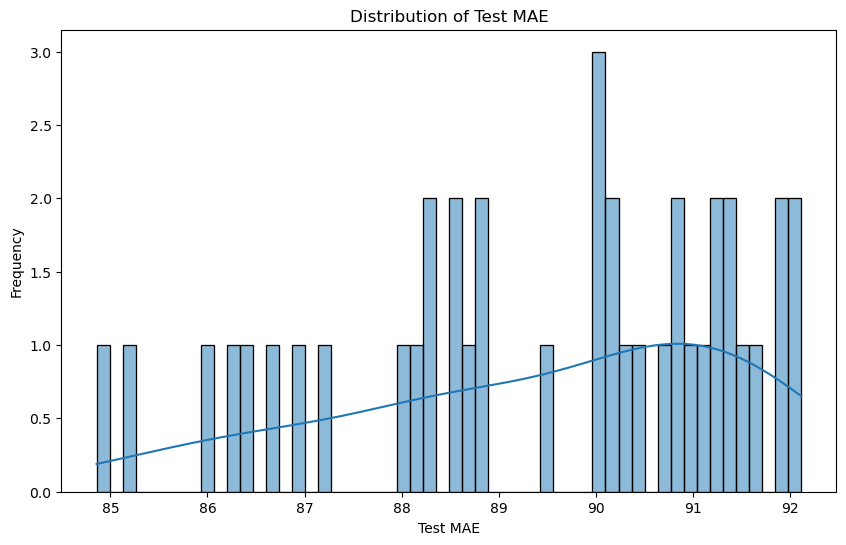

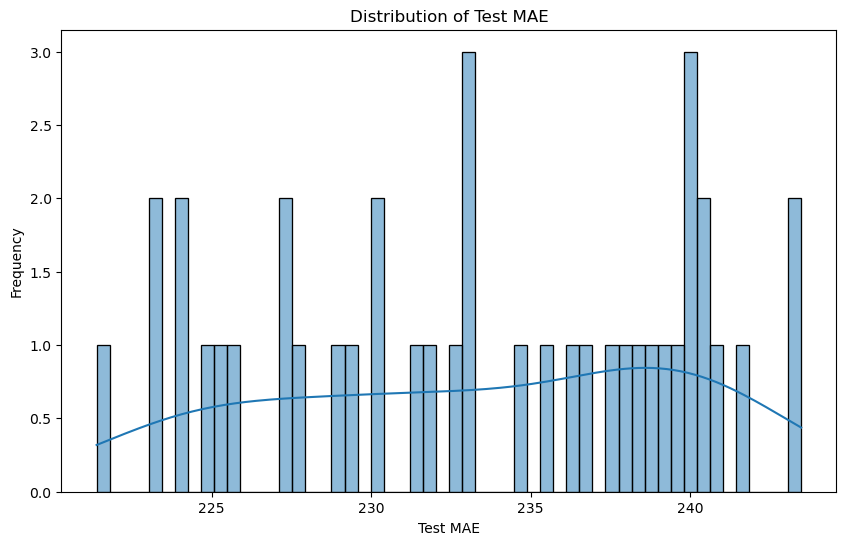

In [40]:
plot_mae_histogram(filter_top_n_by_test_mae(combined_30min, n=40))
plot_mae_histogram(filter_top_n_by_test_mae(combined_4h, n=40))
plot_mae_histogram(filter_top_n_by_test_mae(combined_1d, n=40))

In [8]:
# Create box plots
def create_box_plot(df, feature, target='test_mae'):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=feature, y=target, data=df)
    plt.title(f'Box plot of {target} by {feature}')
    plt.show()



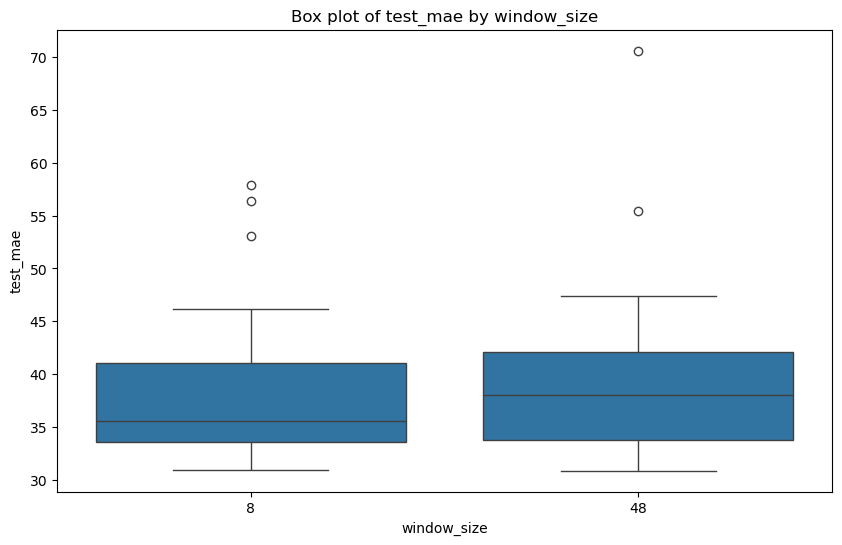

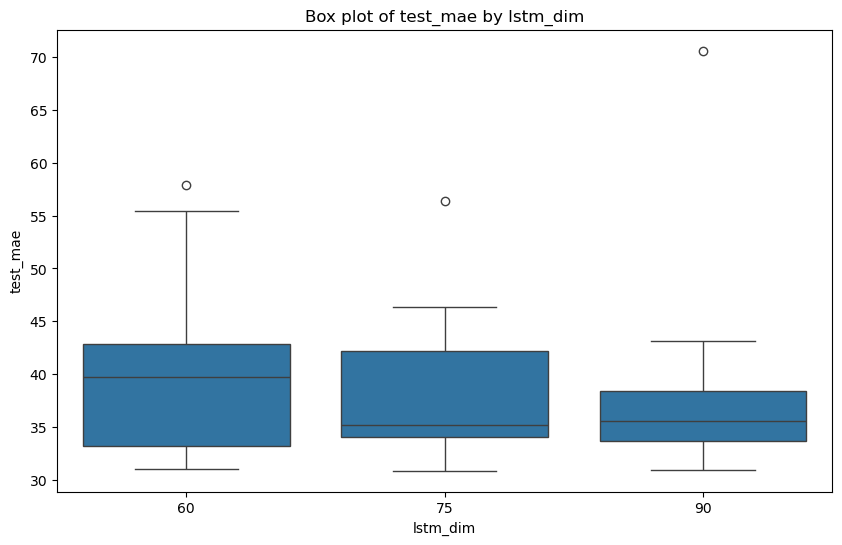

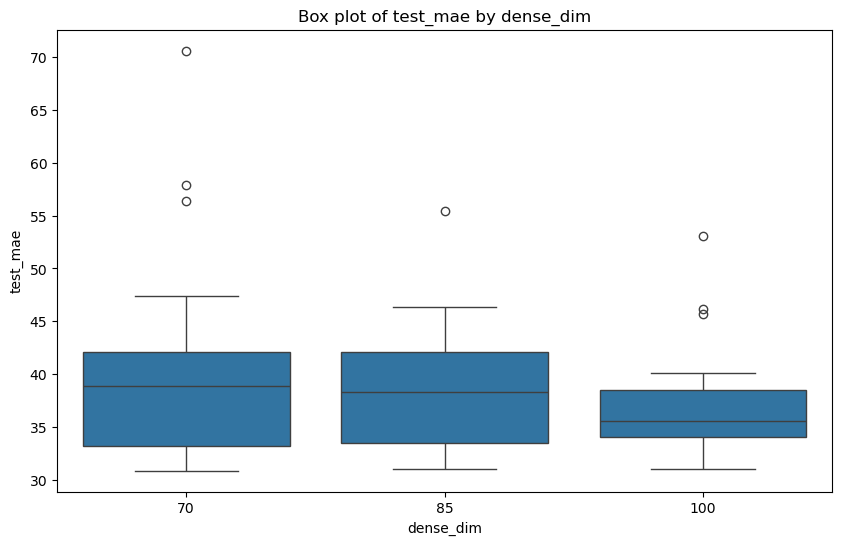

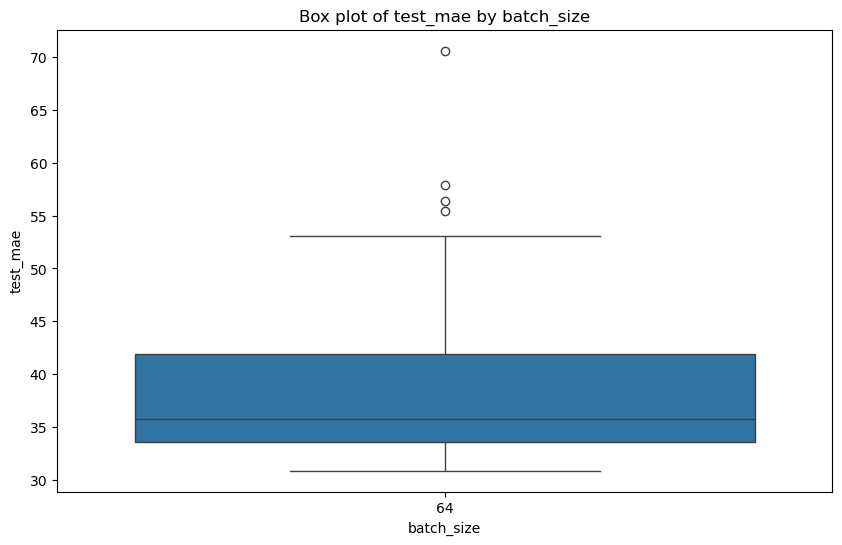

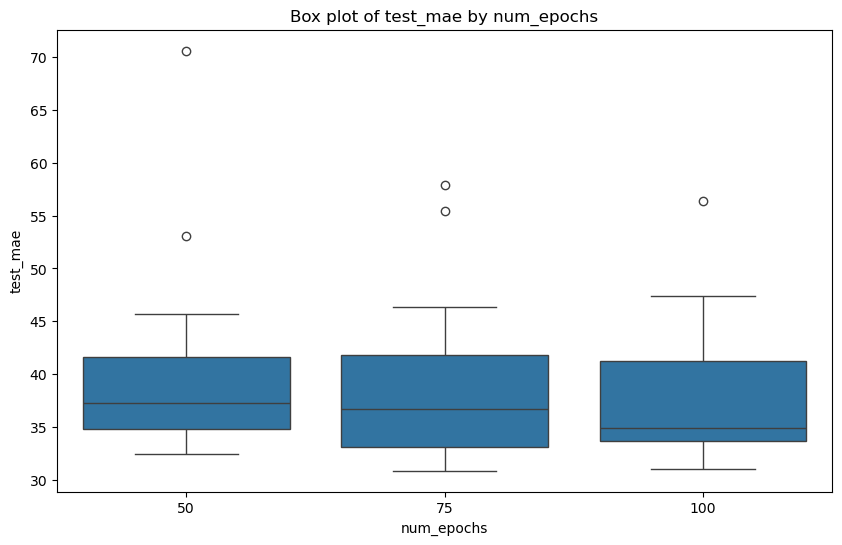

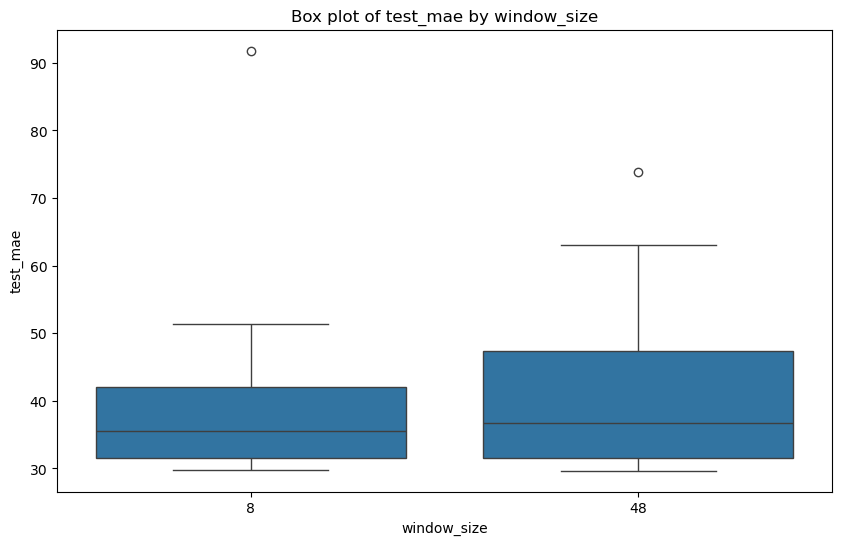

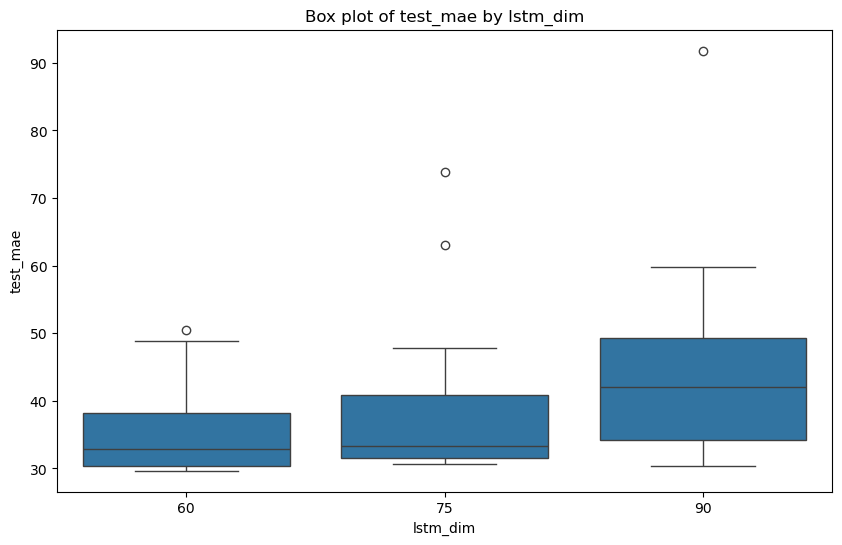

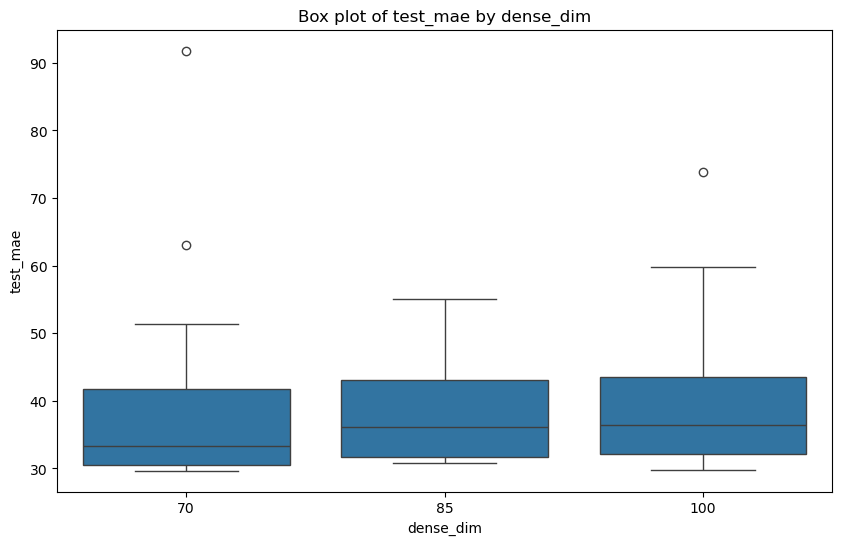

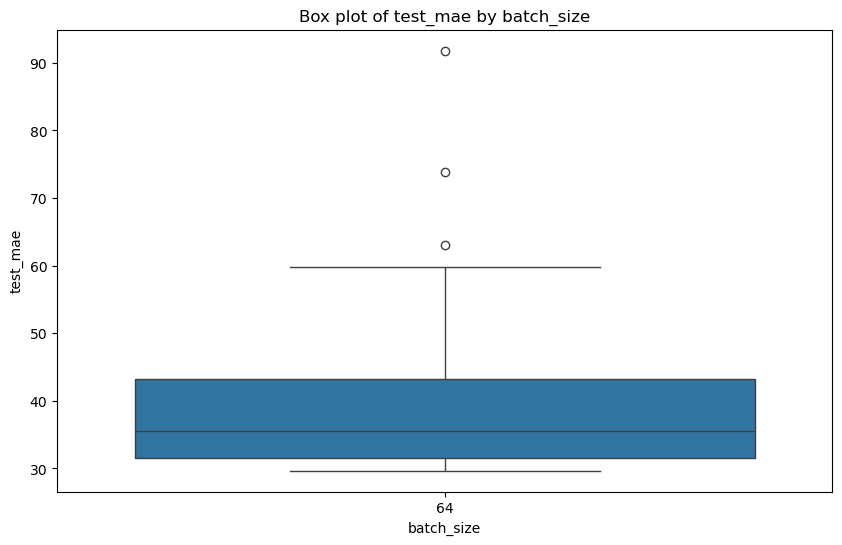

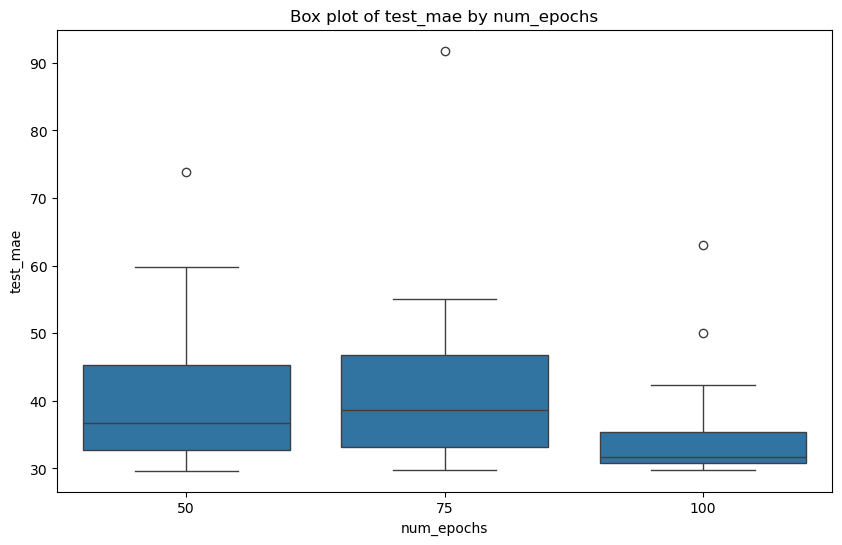

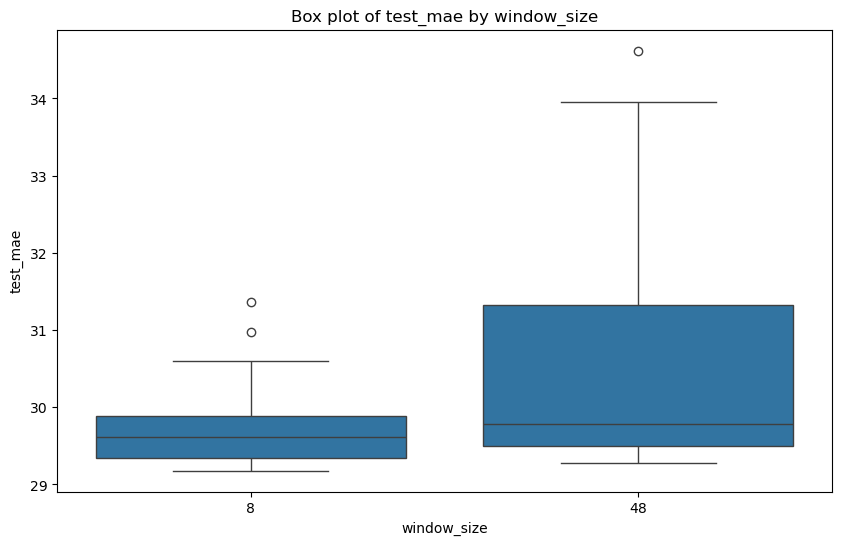

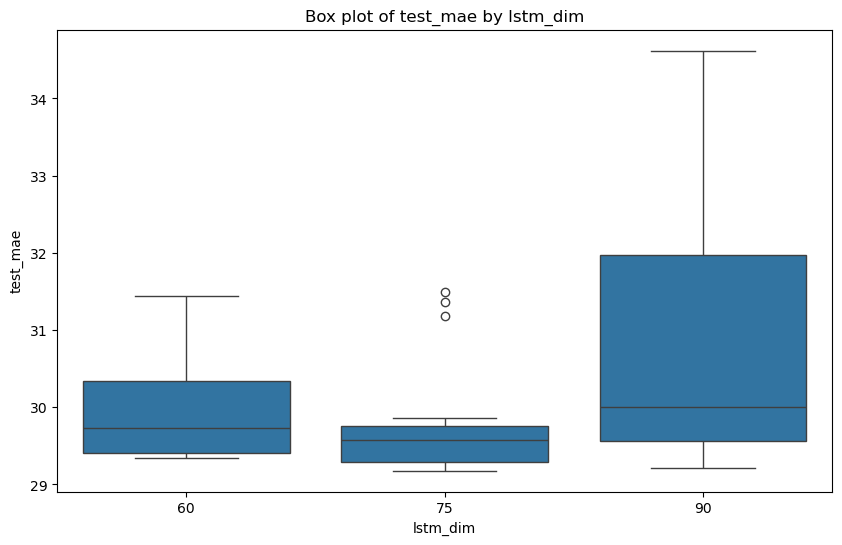

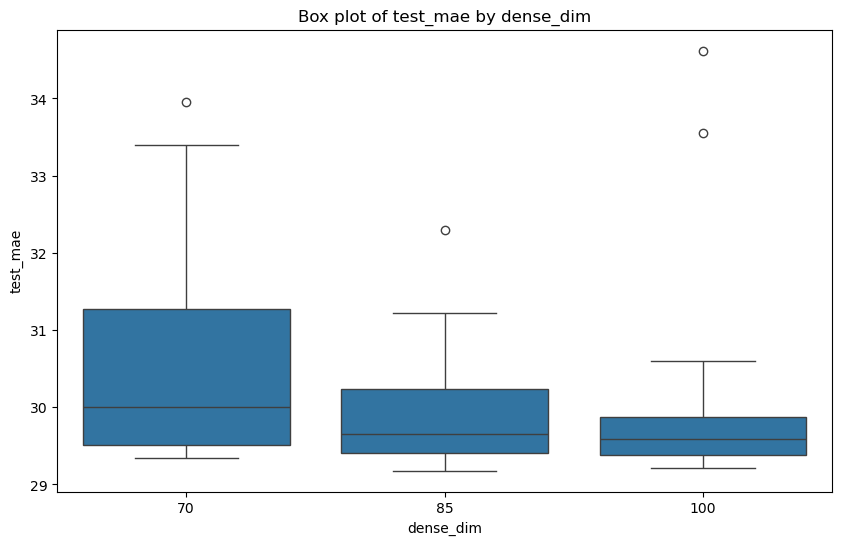

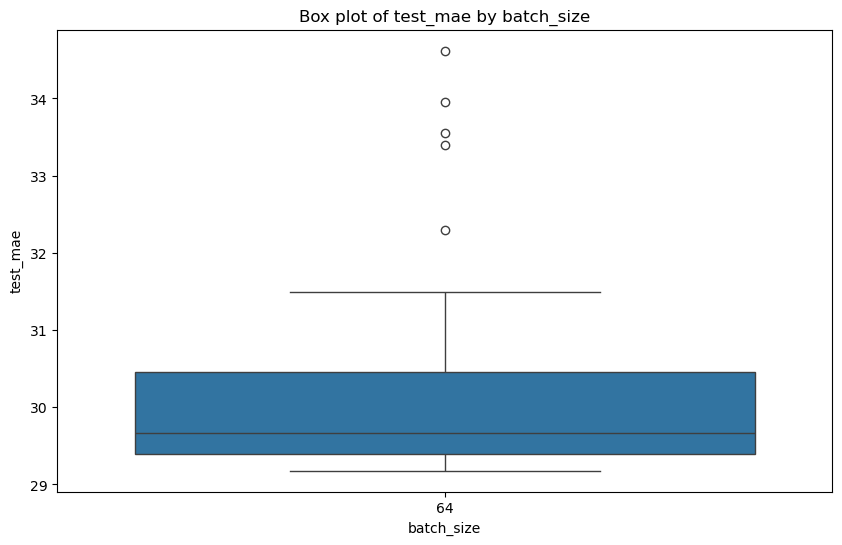

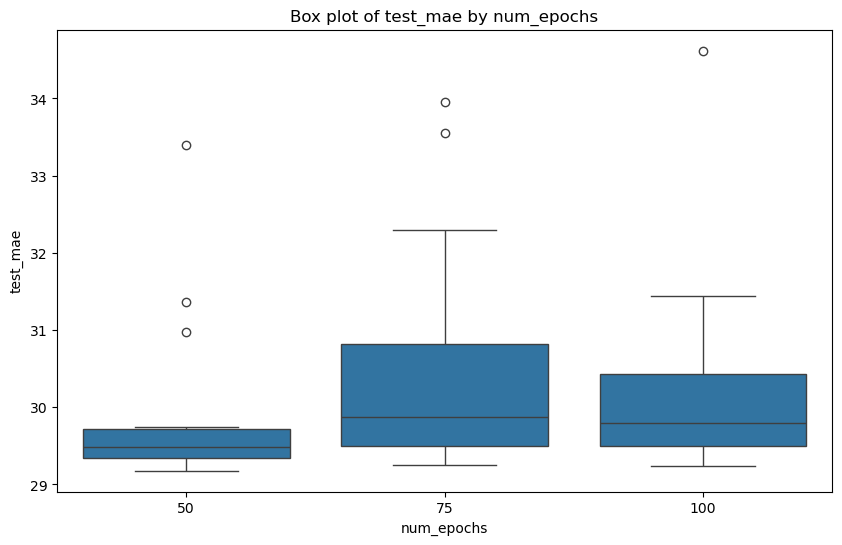

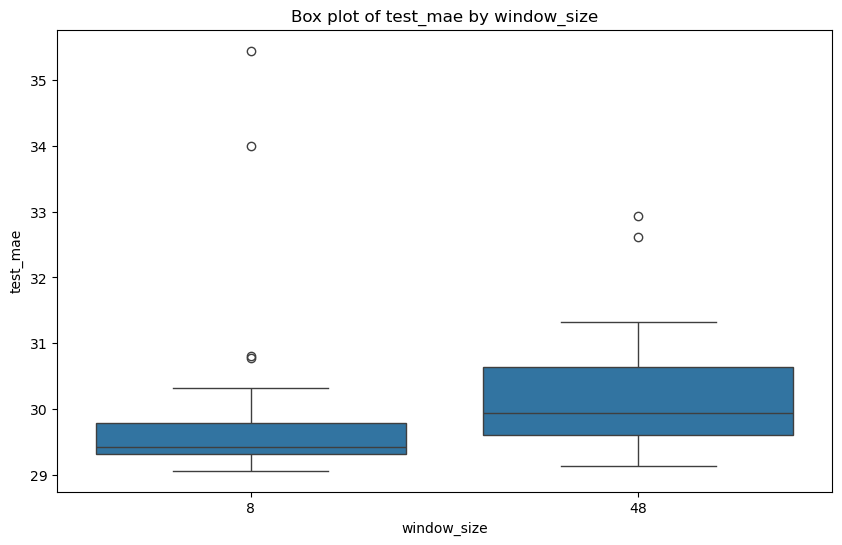

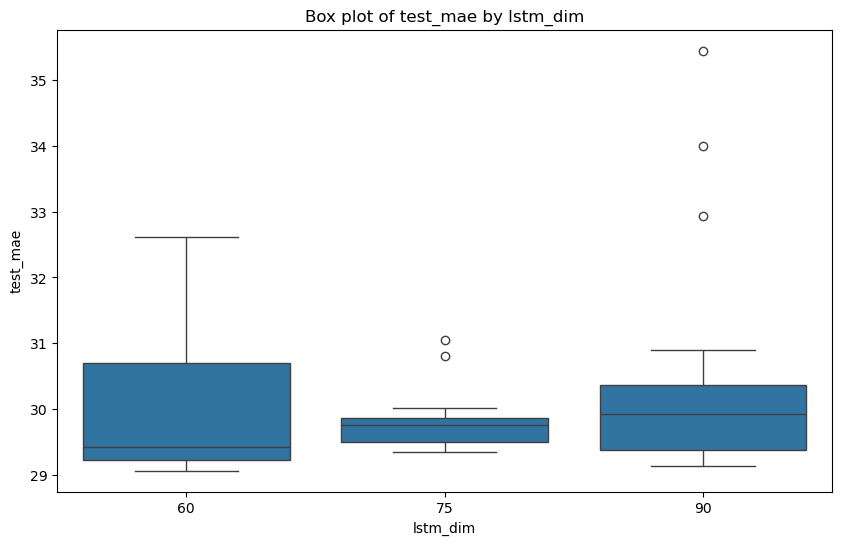

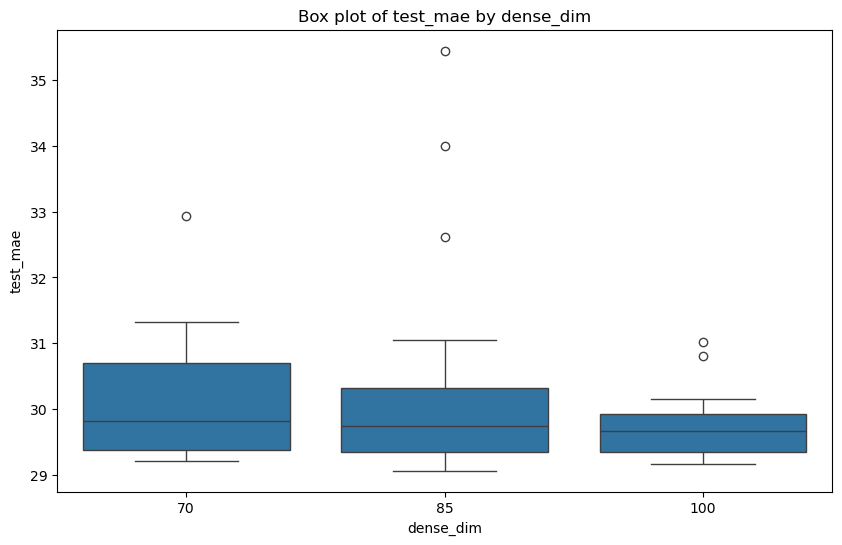

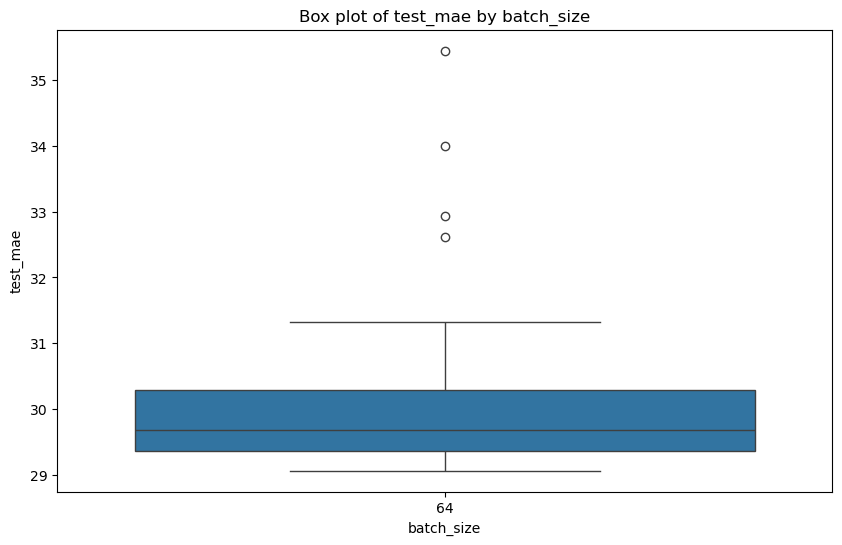

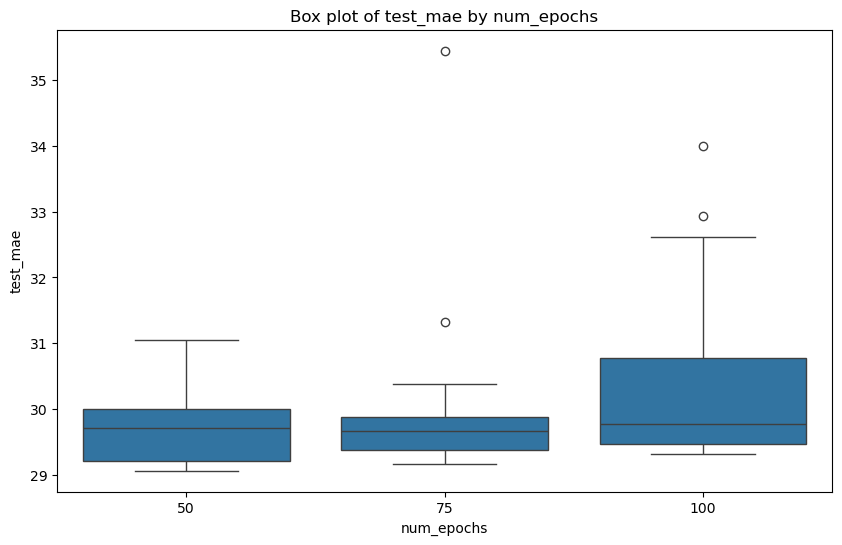

In [14]:
for df in dfs_30min:
    for feature in features_of_interest:
        create_box_plot(df, feature=feature, target='test_mae')

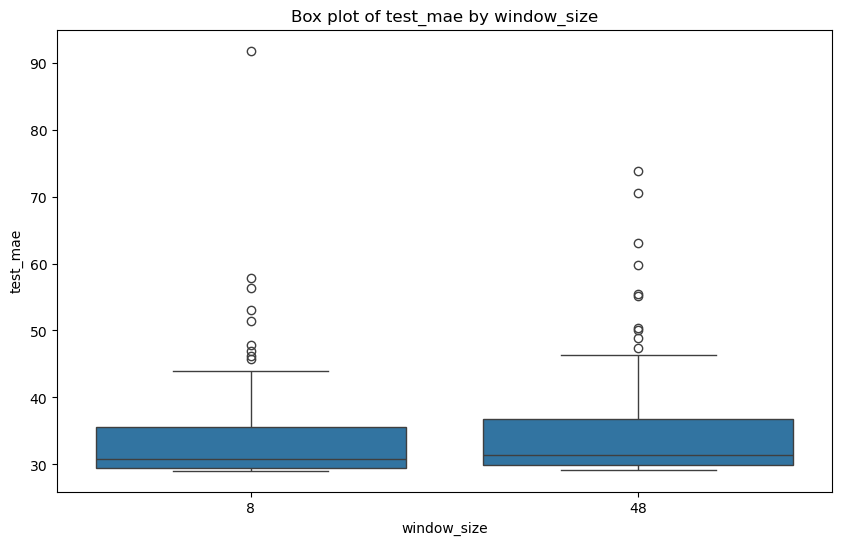

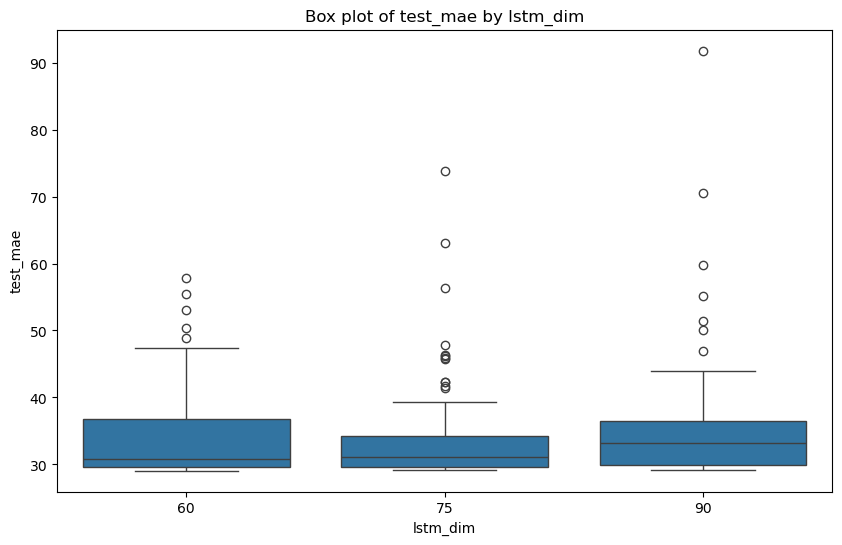

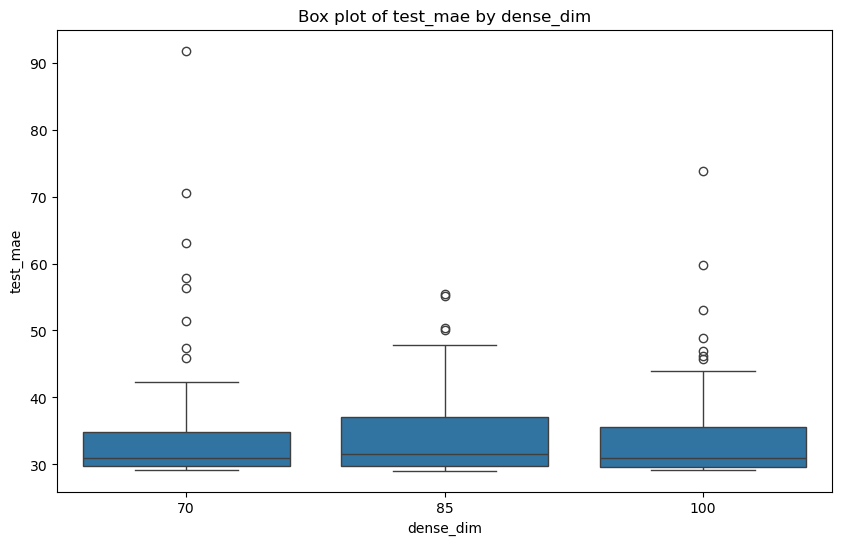

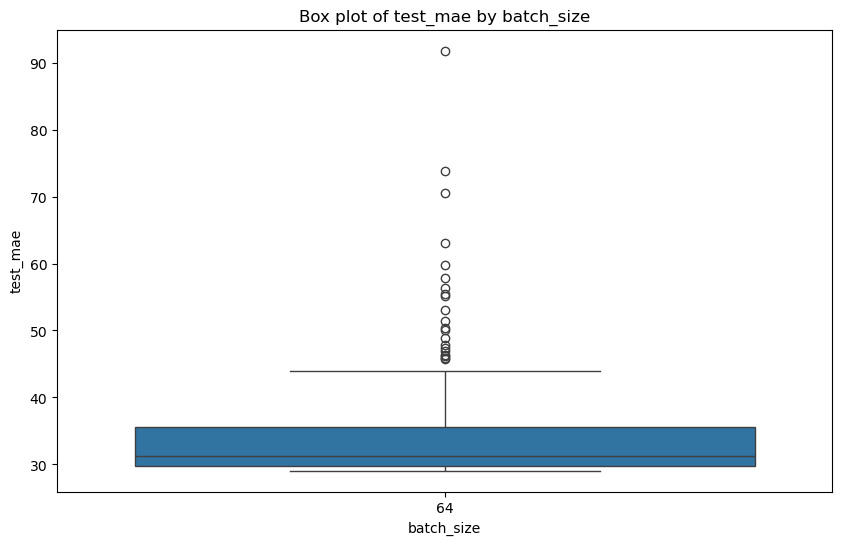

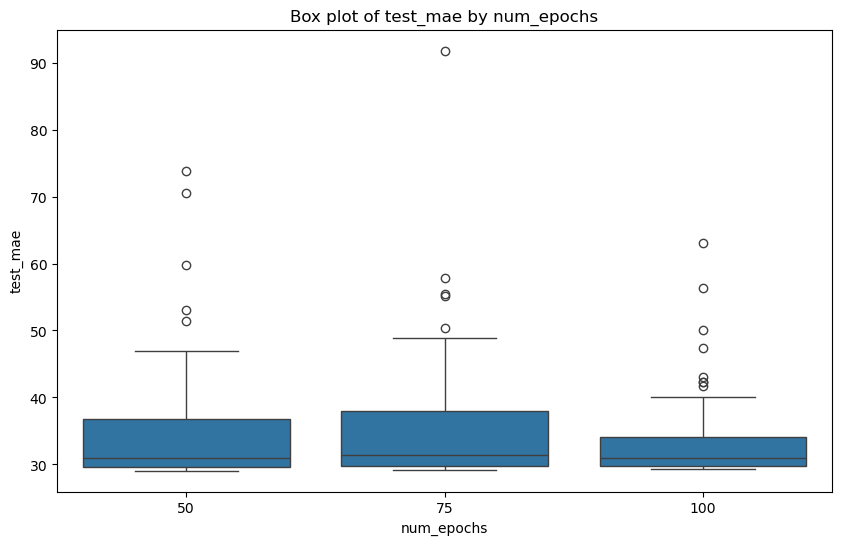

In [95]:
for feature in features_of_interest:
        create_box_plot(combined_30min, feature=feature, target='test_mae')

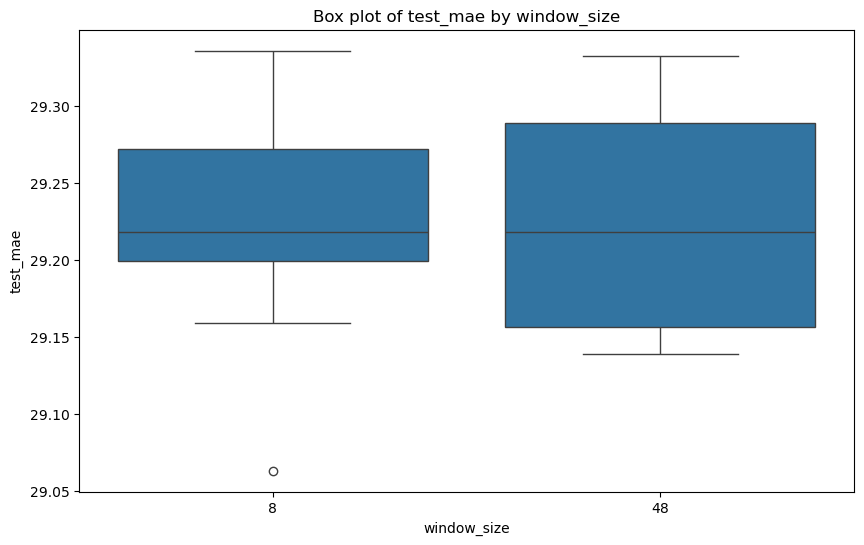

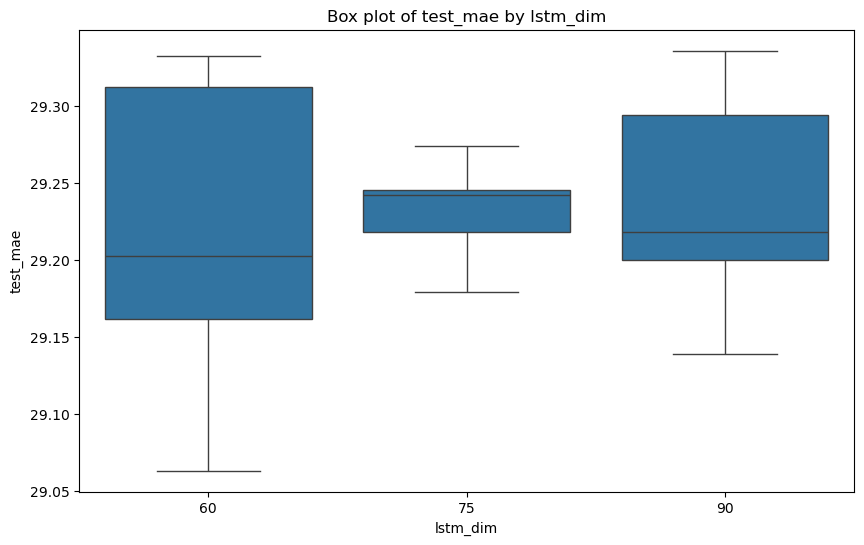

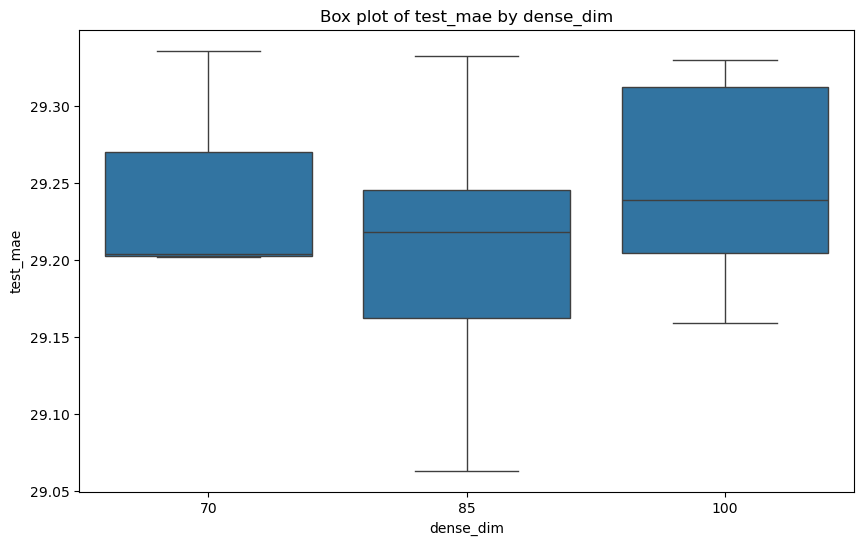

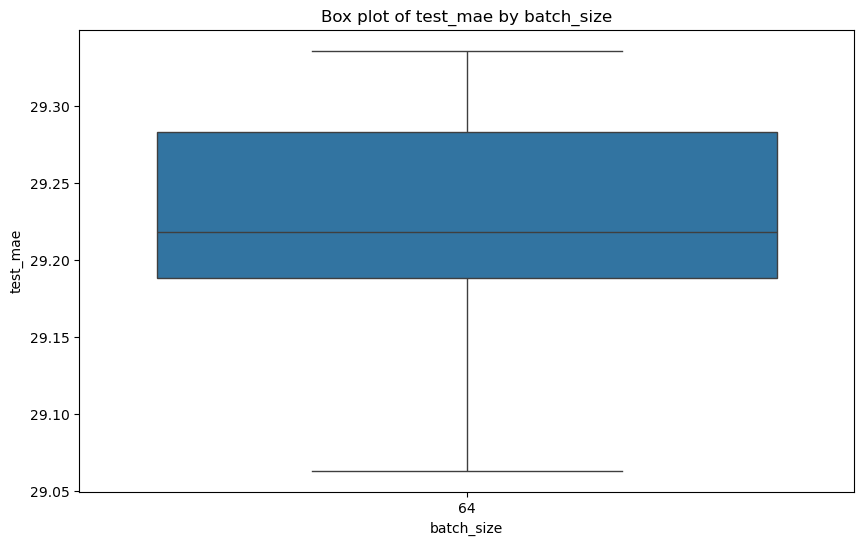

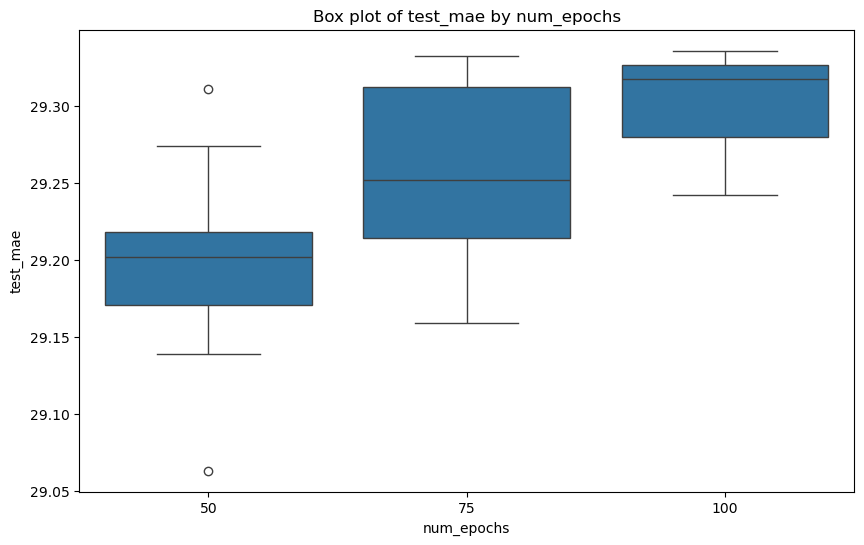

In [96]:
for feature in features_of_interest:
        create_box_plot(df_30min_top20, feature=feature, target='test_mae')
    

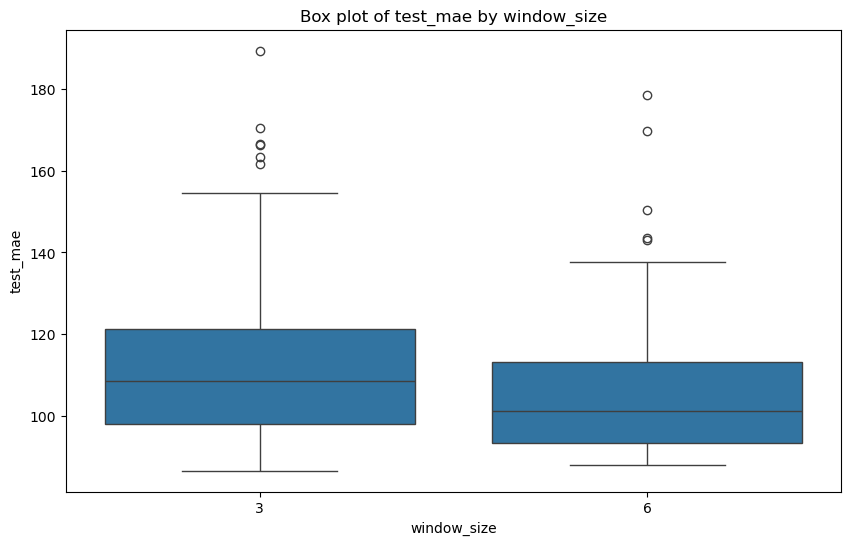

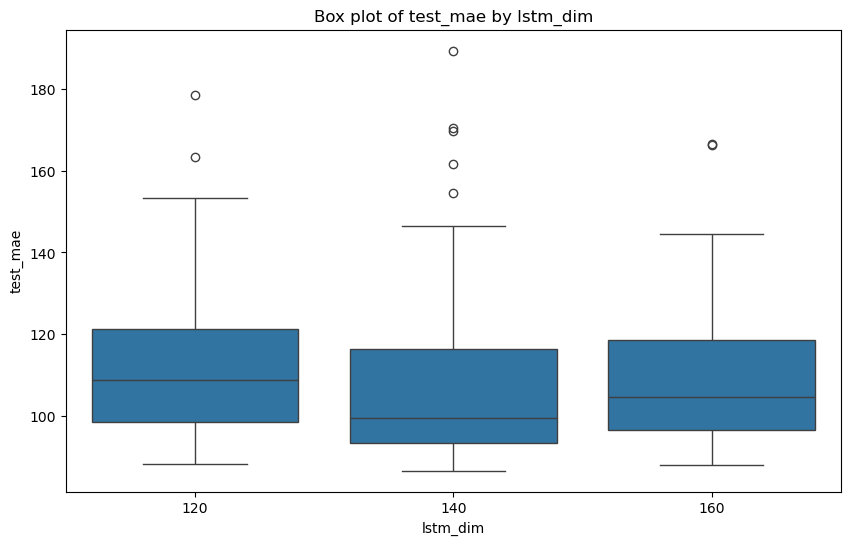

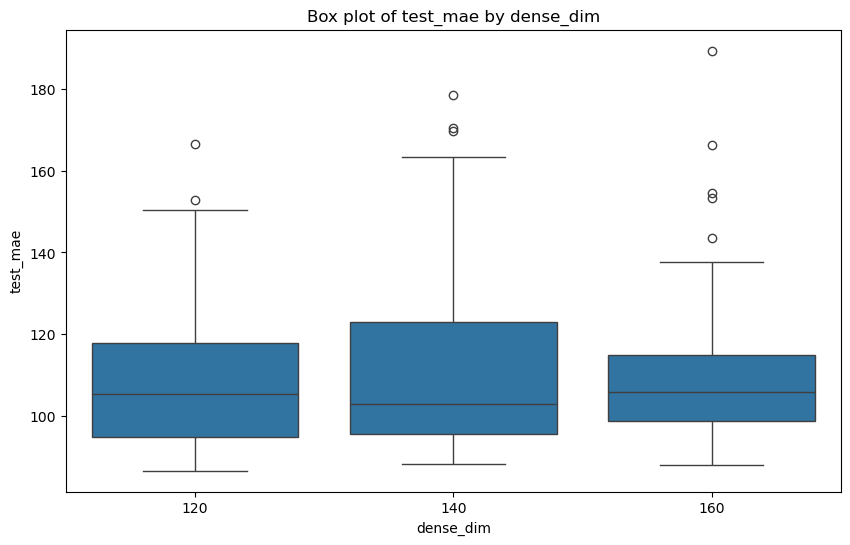

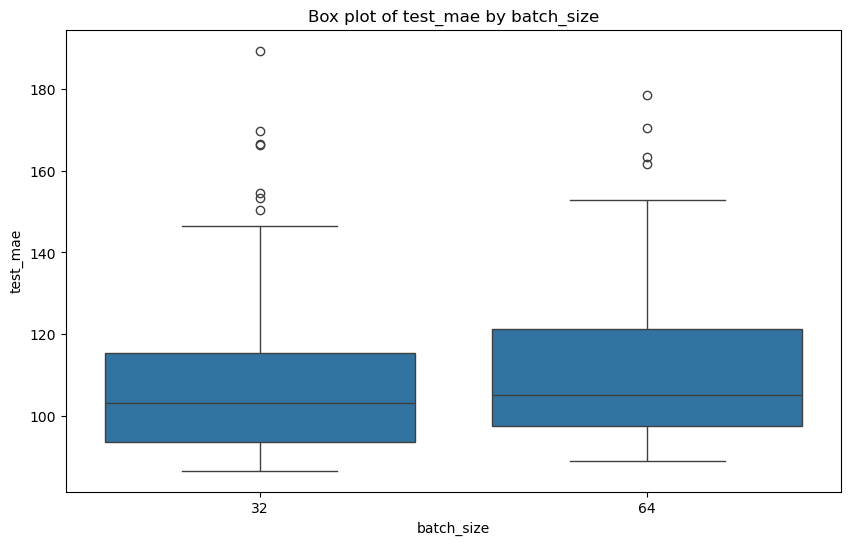

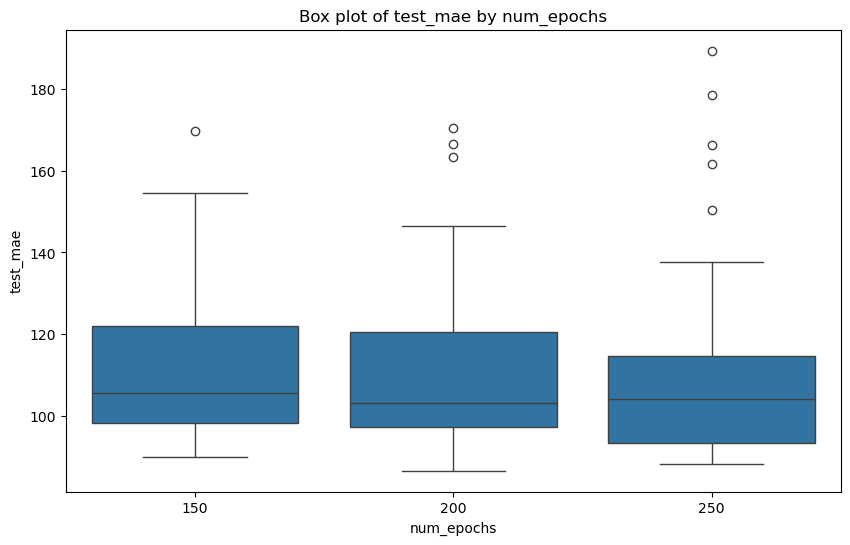

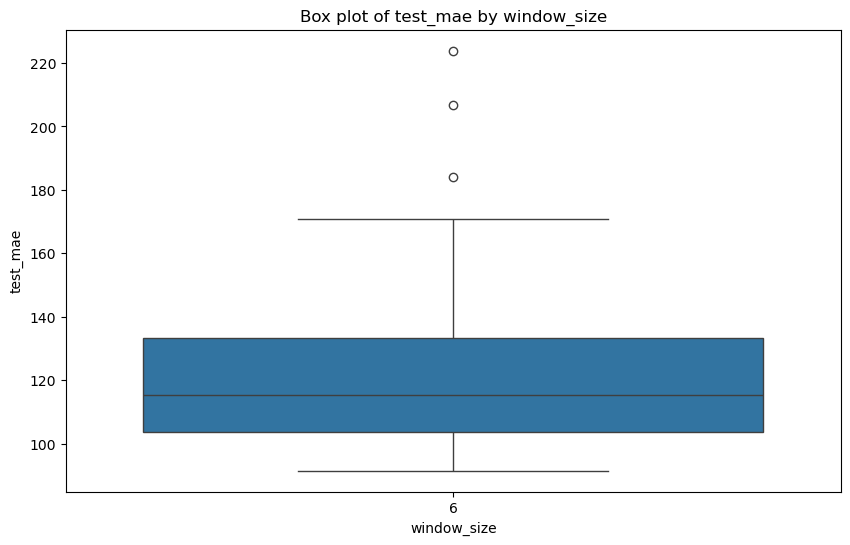

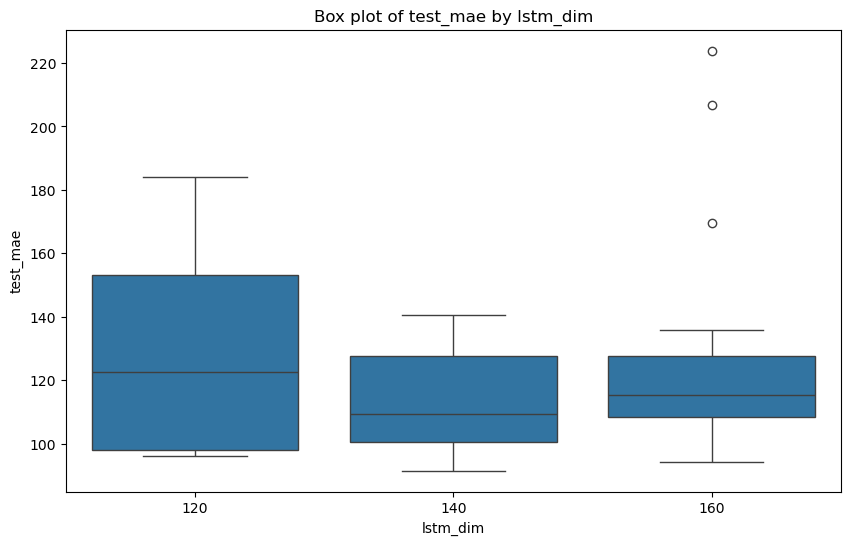

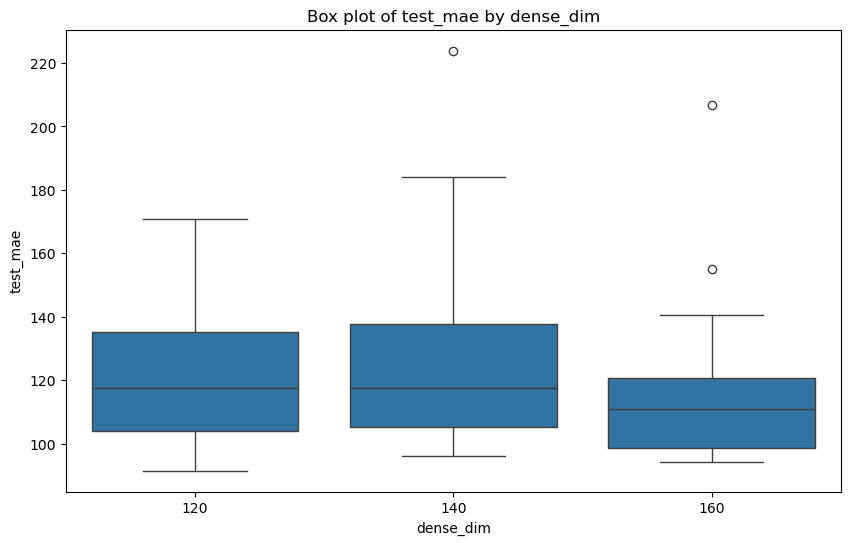

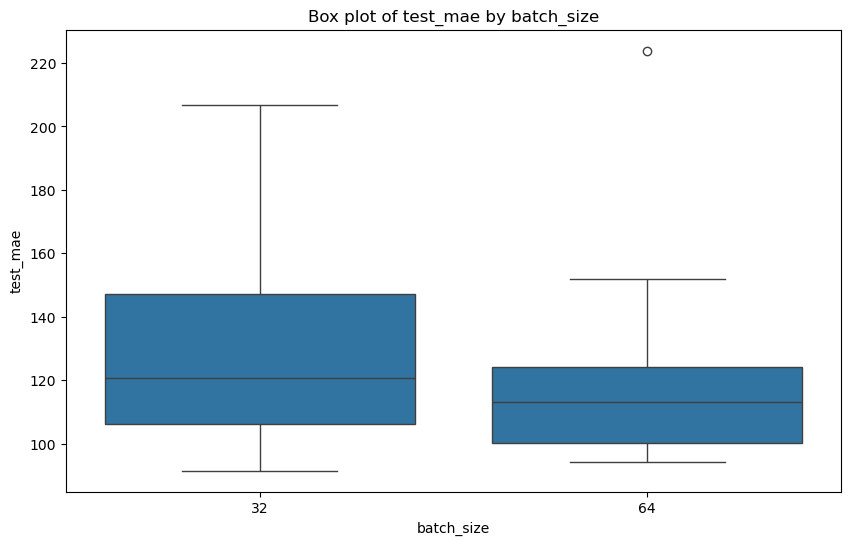

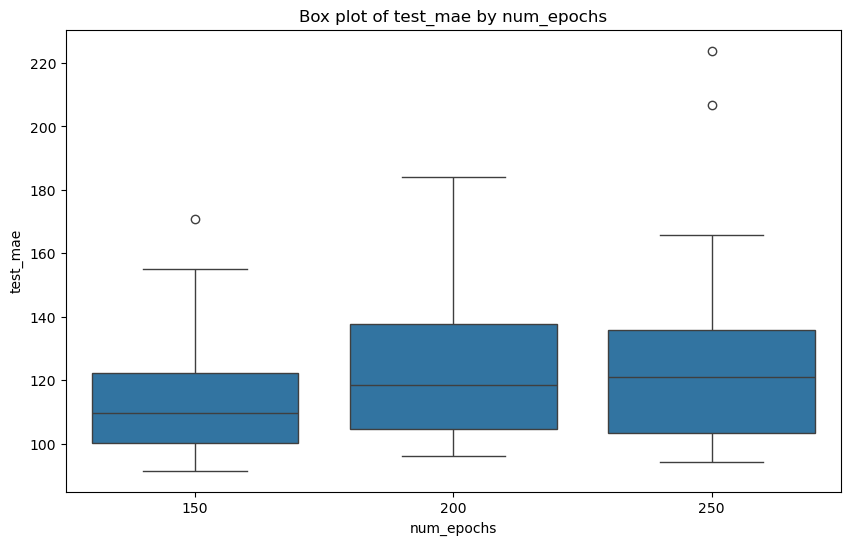

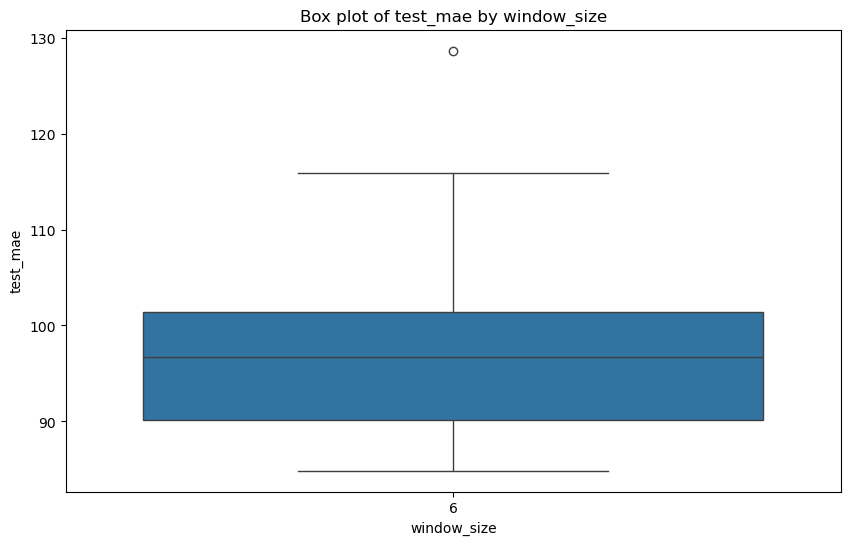

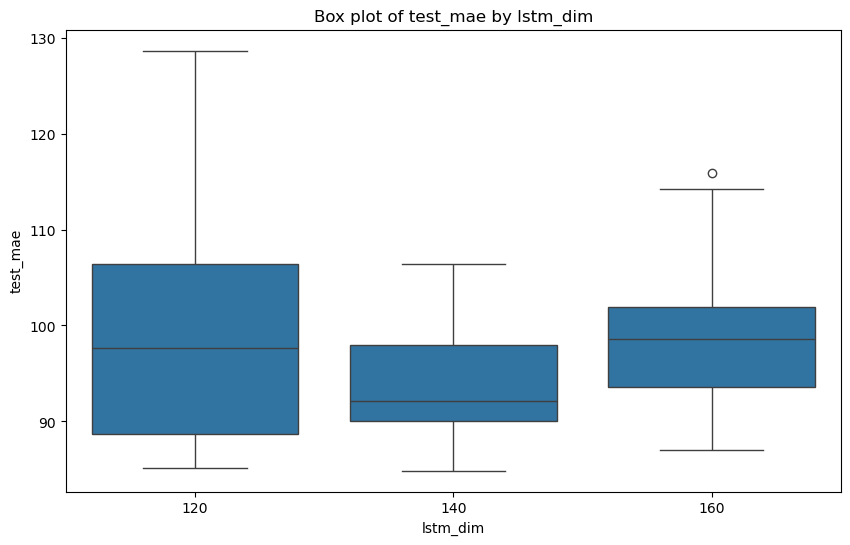

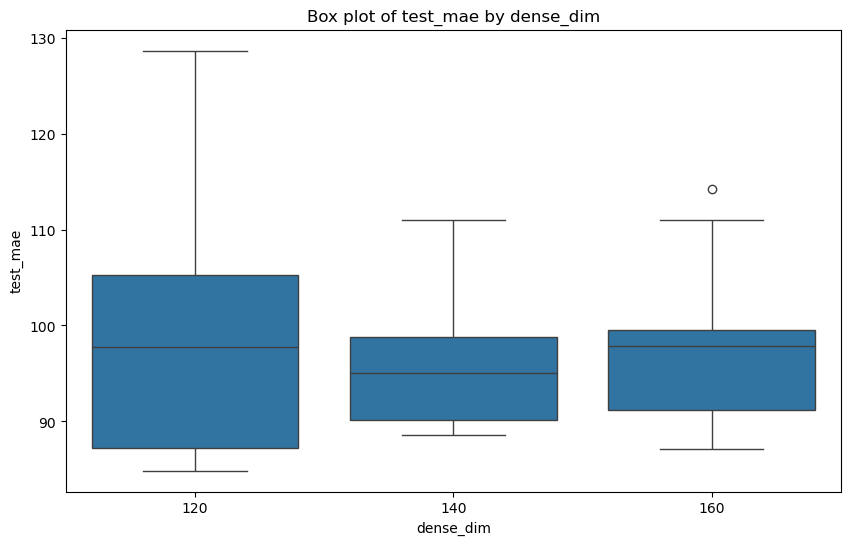

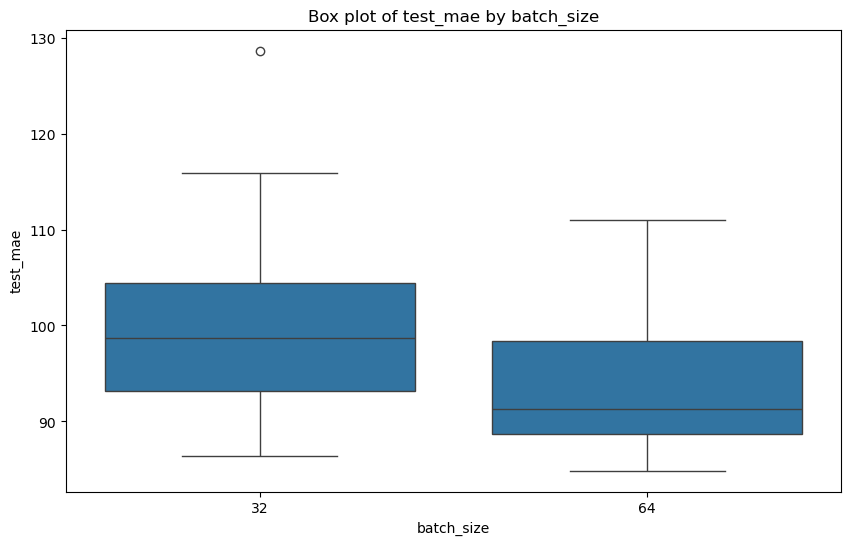

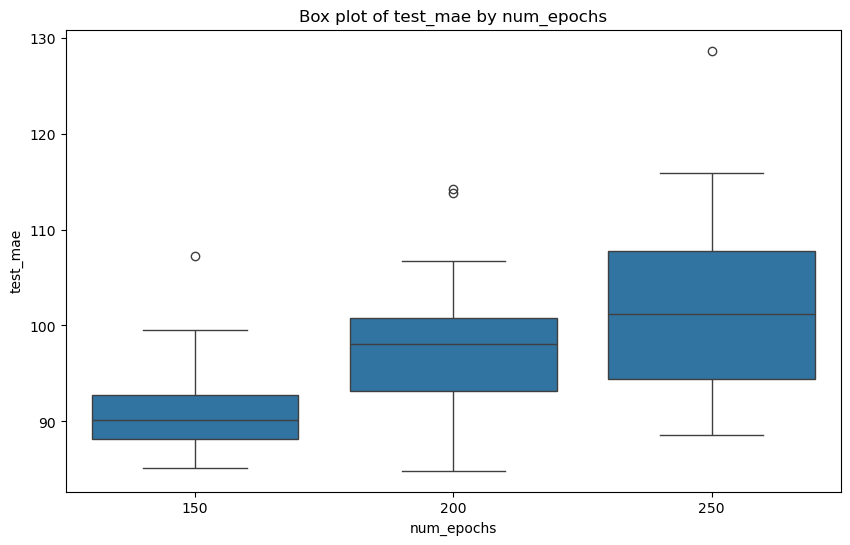

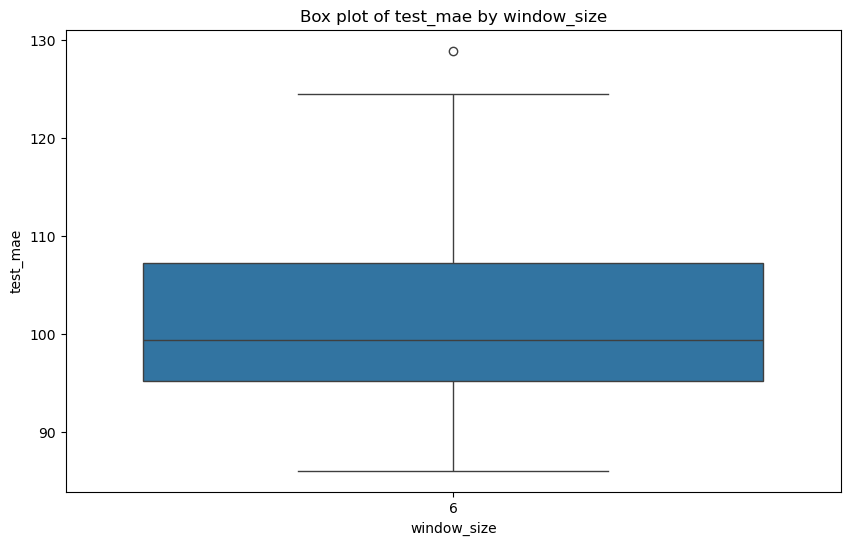

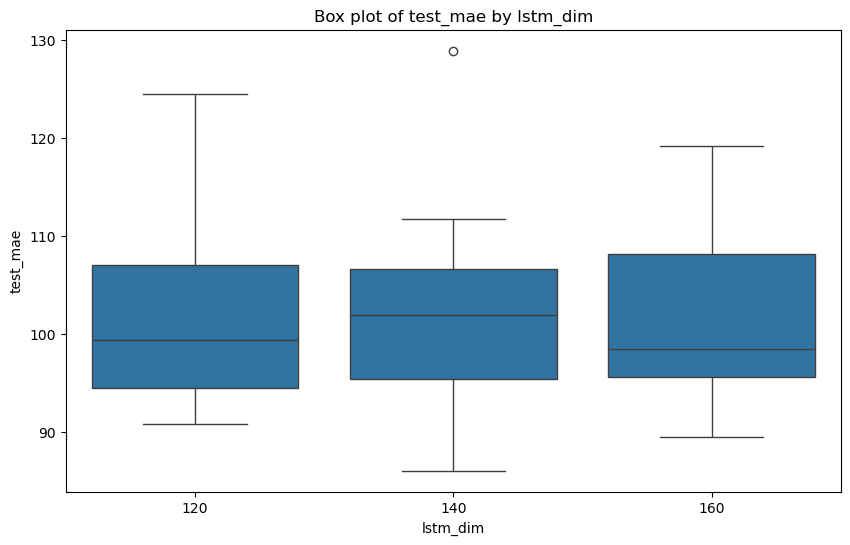

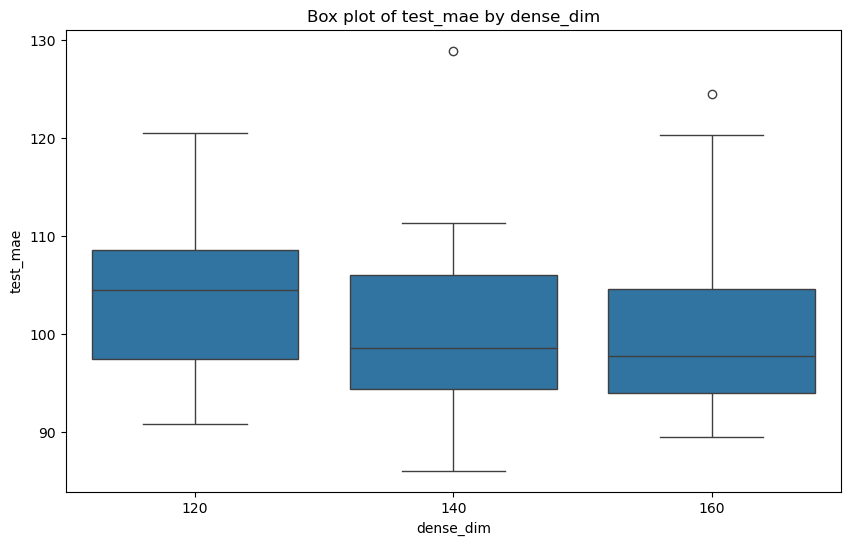

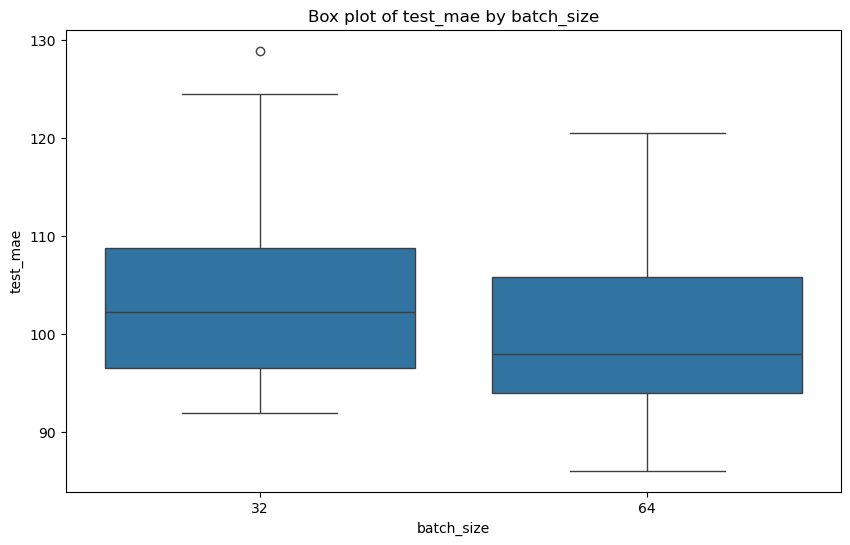

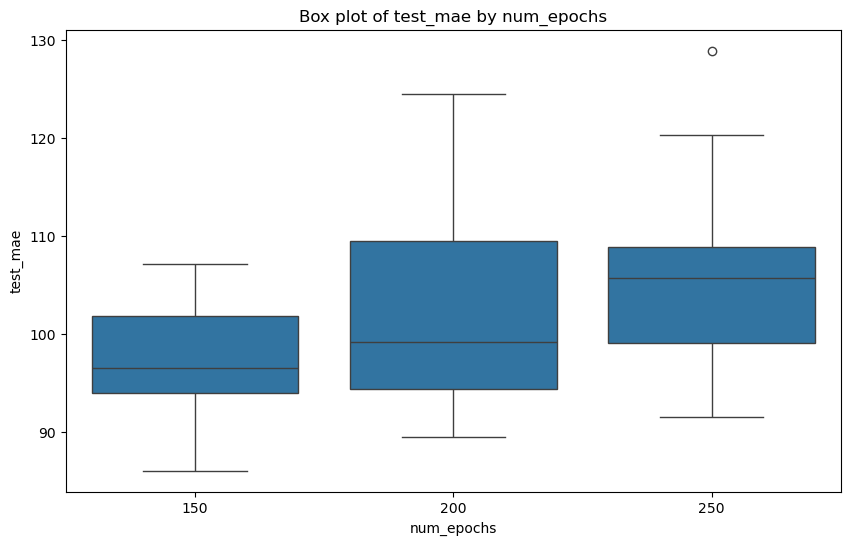

In [21]:
for df in dfs_4h:
    for feature in features_of_interest:
        create_box_plot(df, feature=feature, target='test_mae')

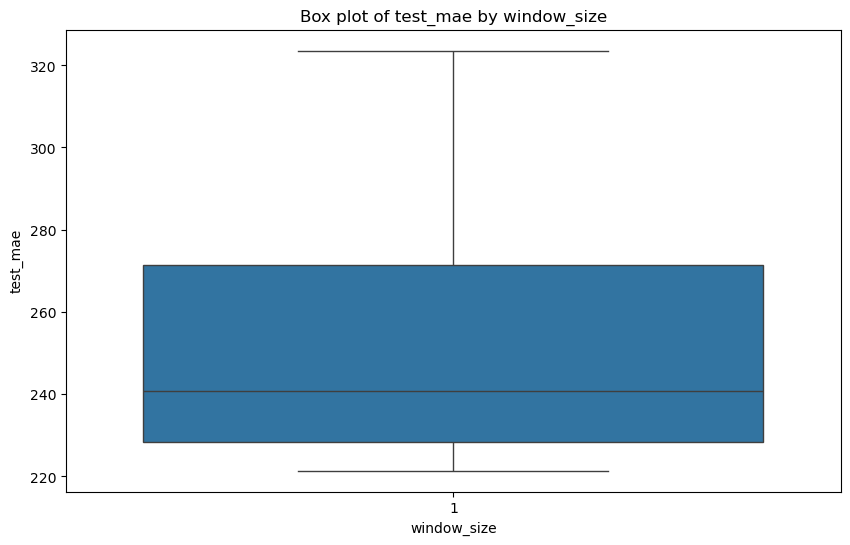

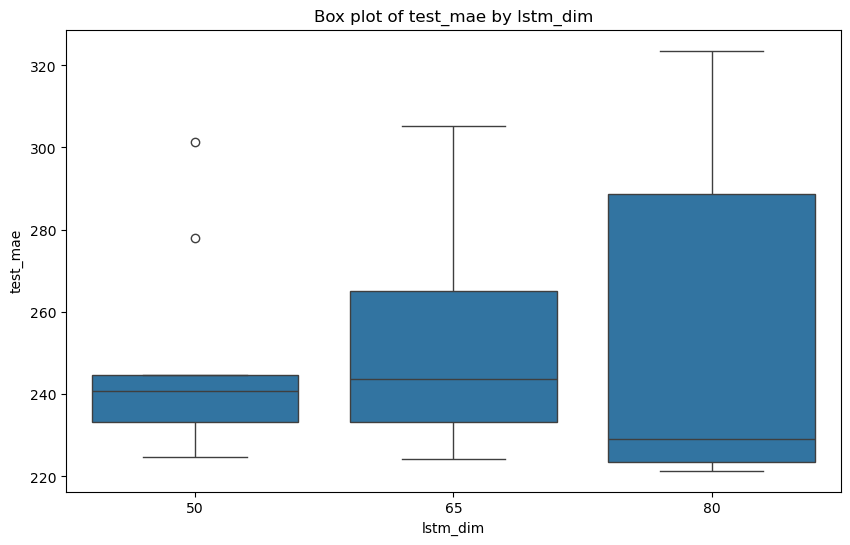

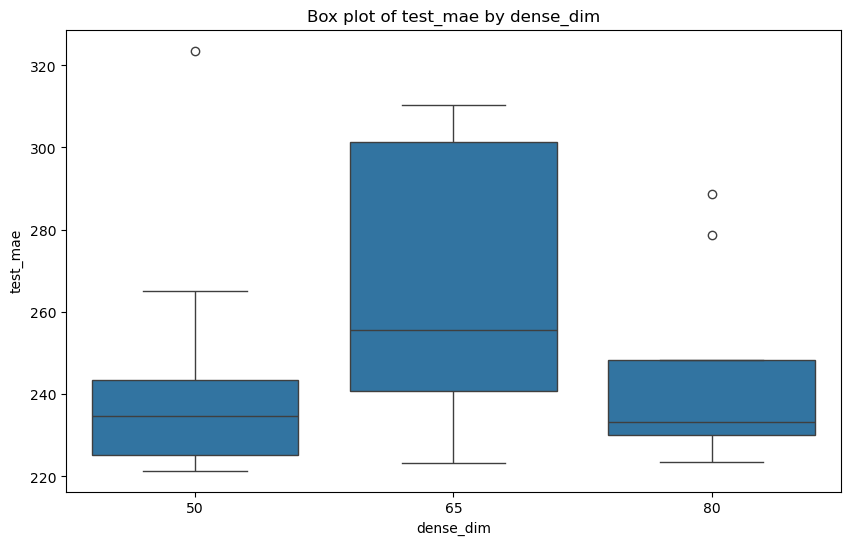

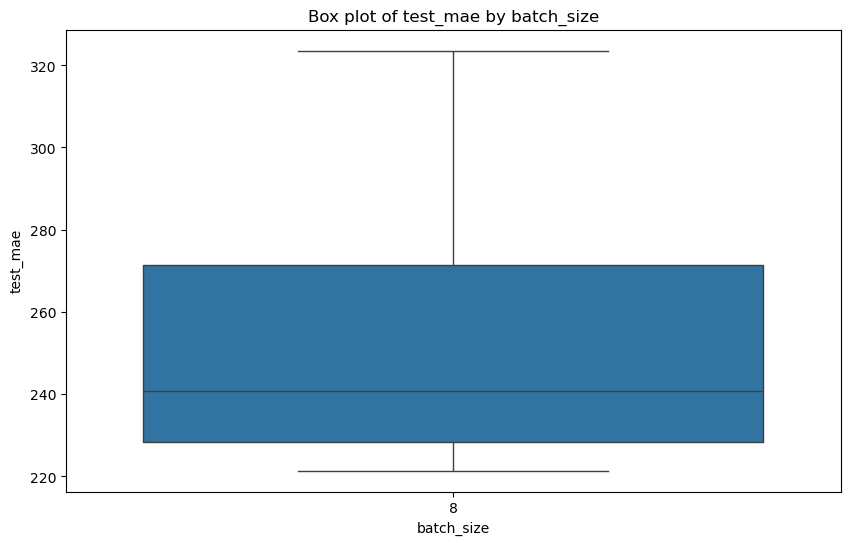

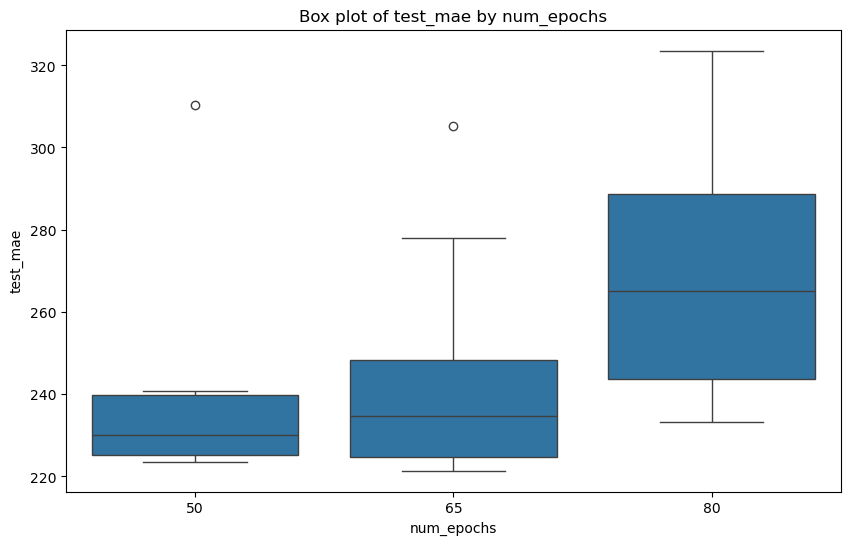

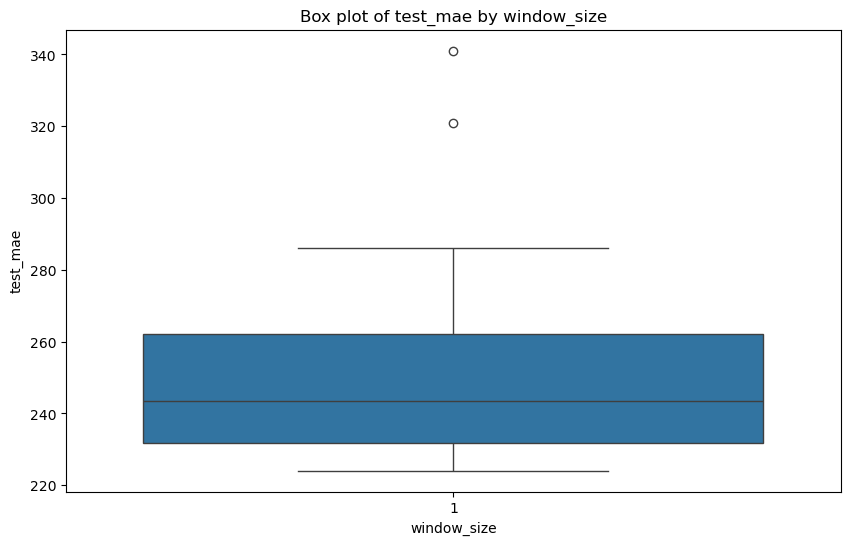

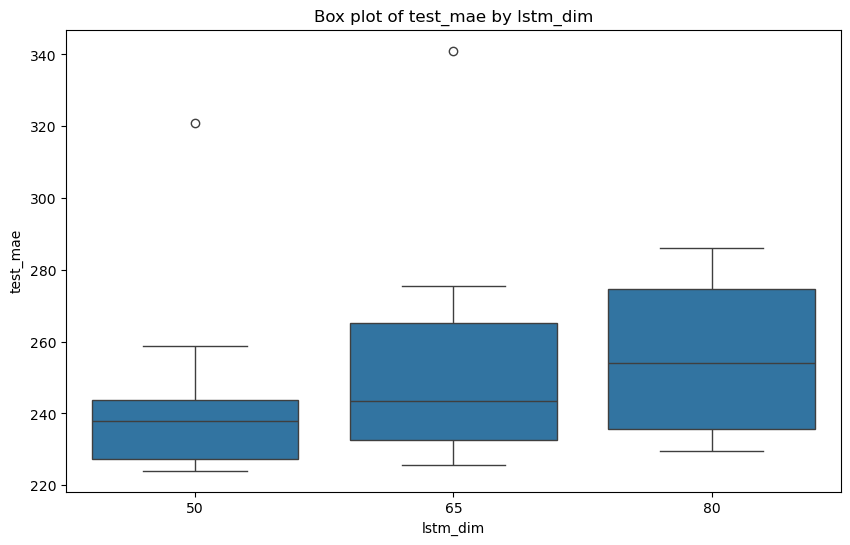

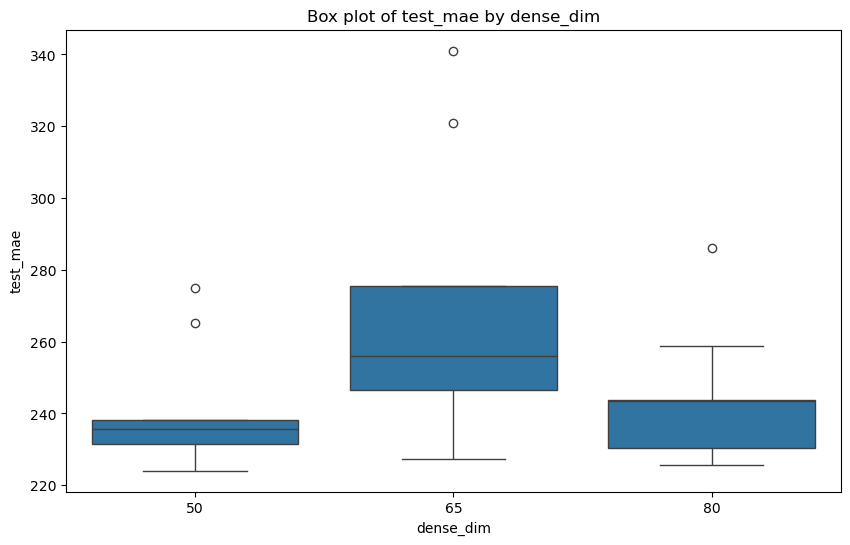

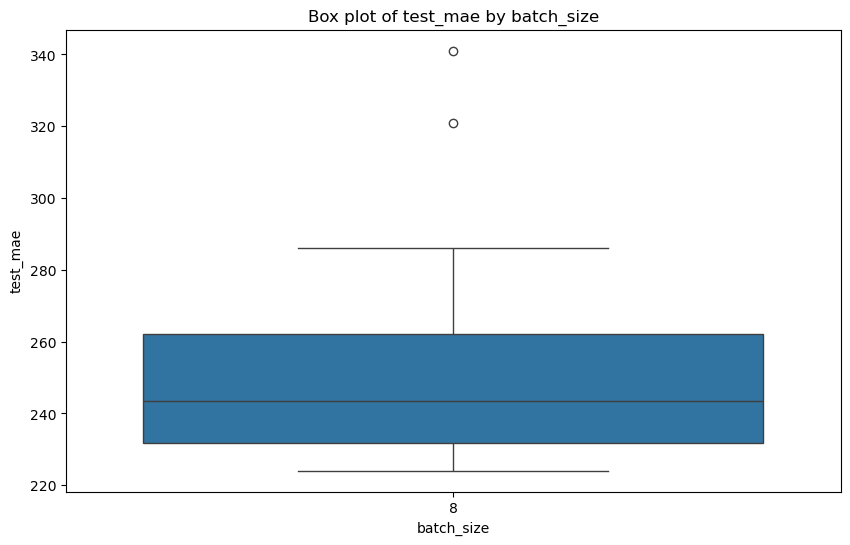

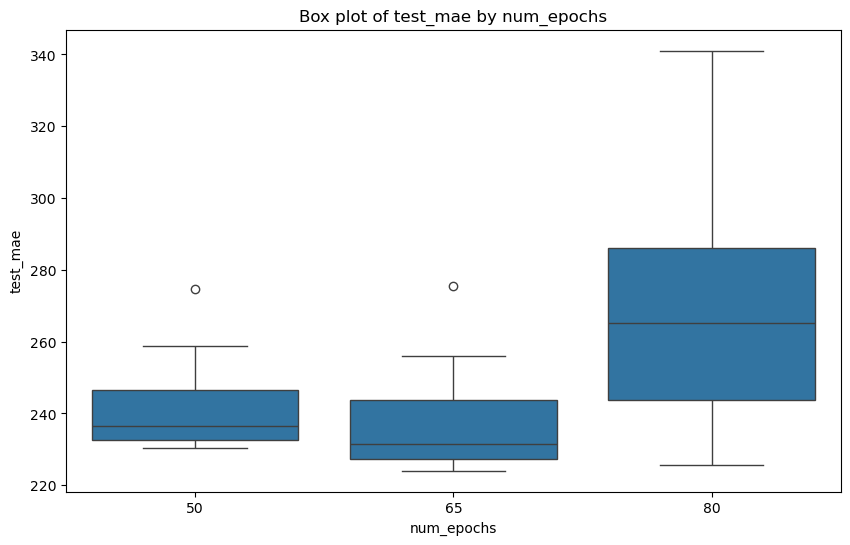

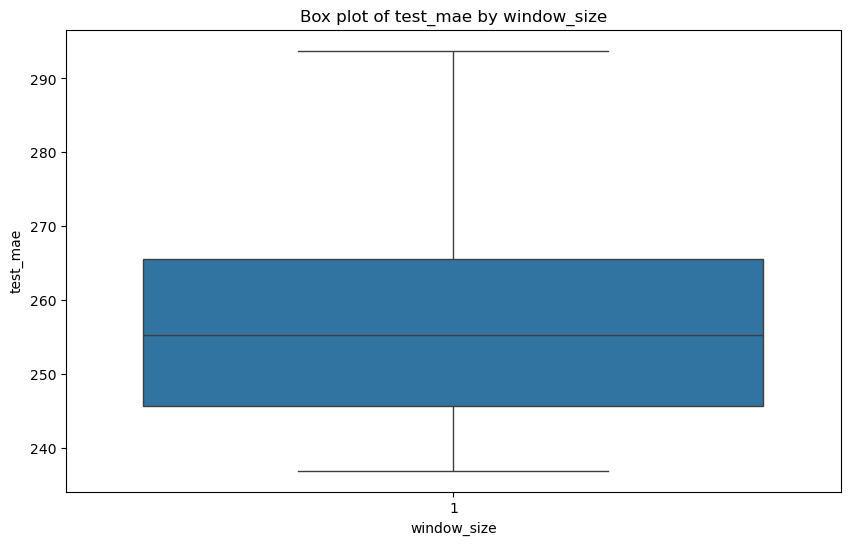

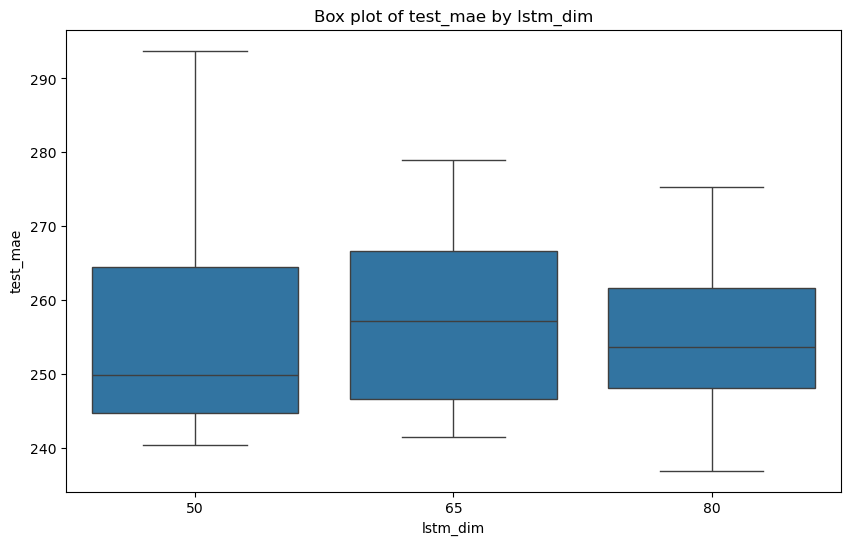

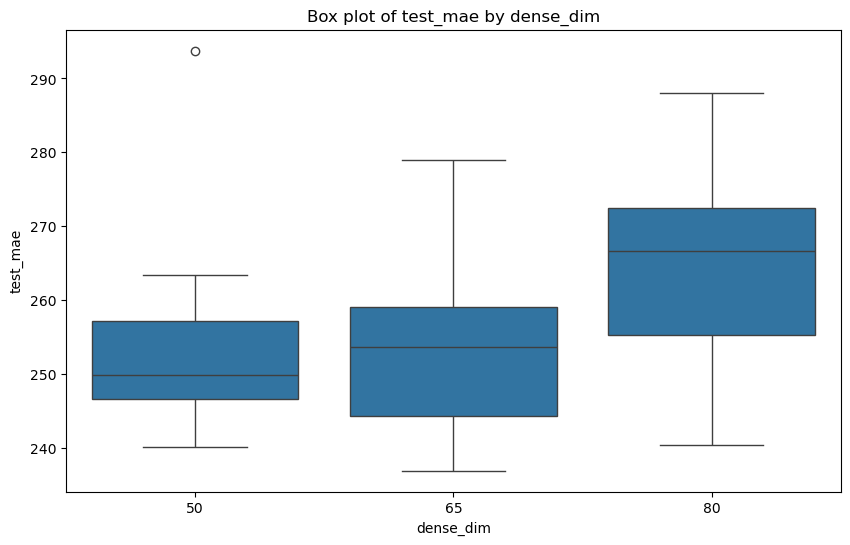

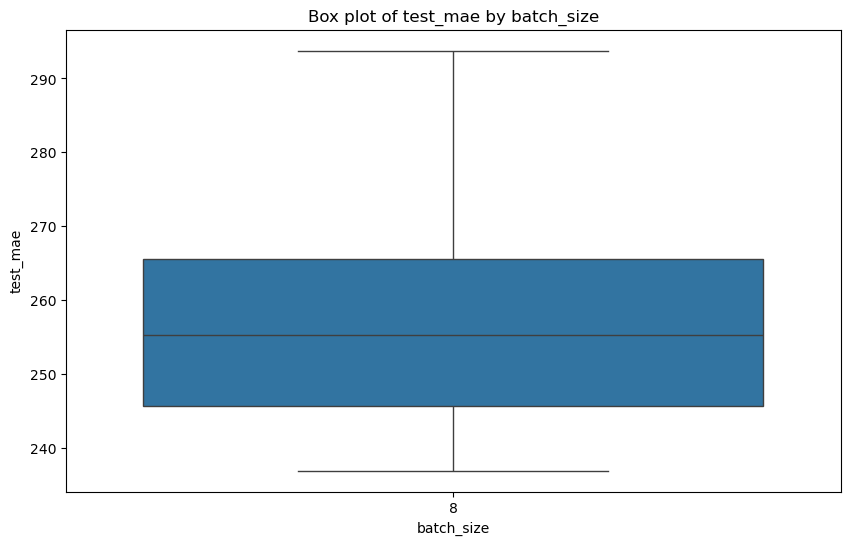

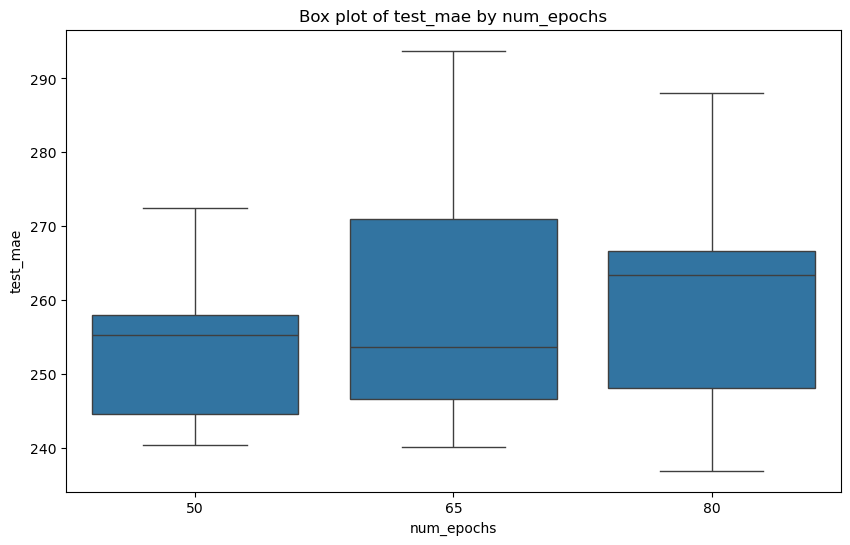

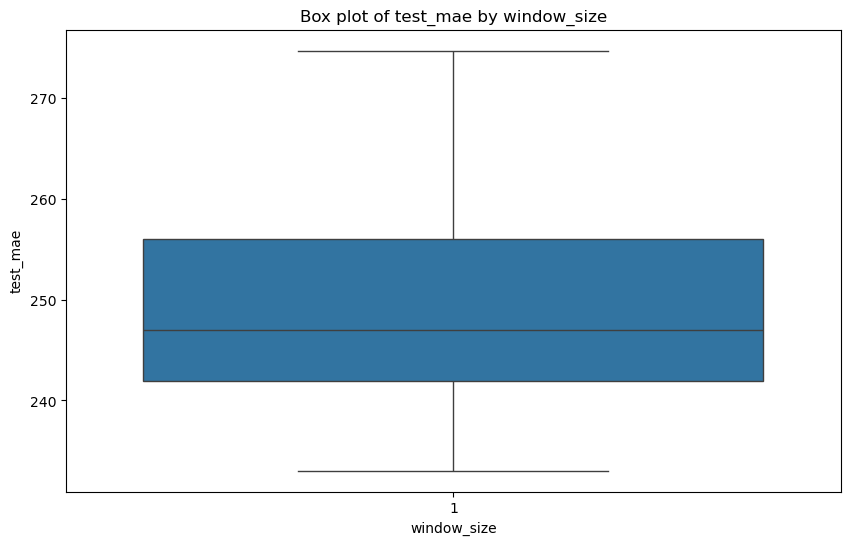

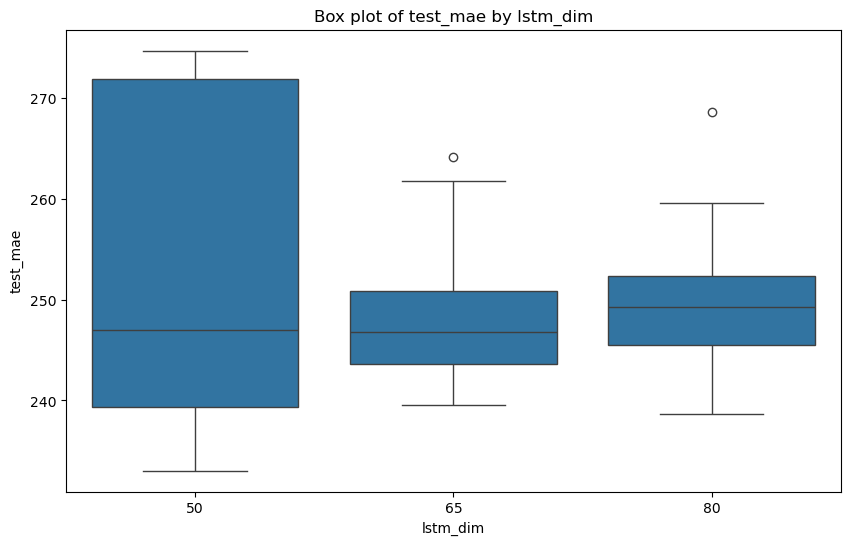

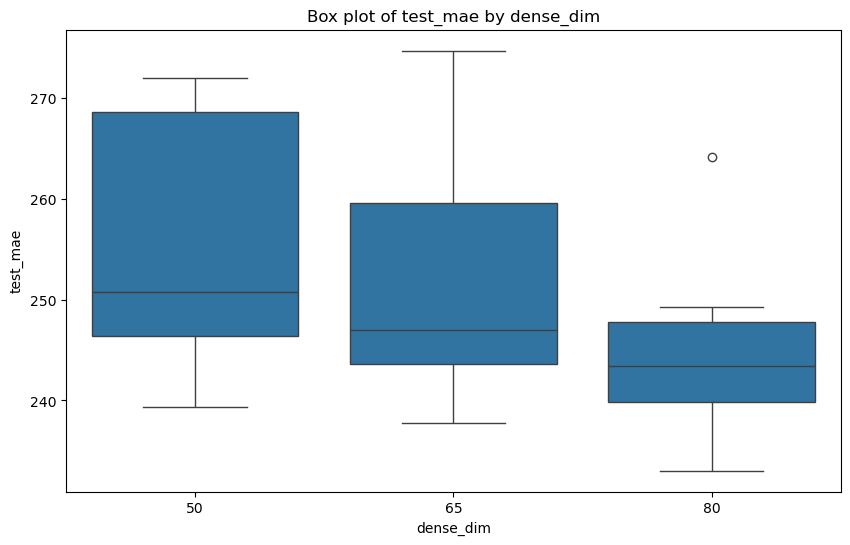

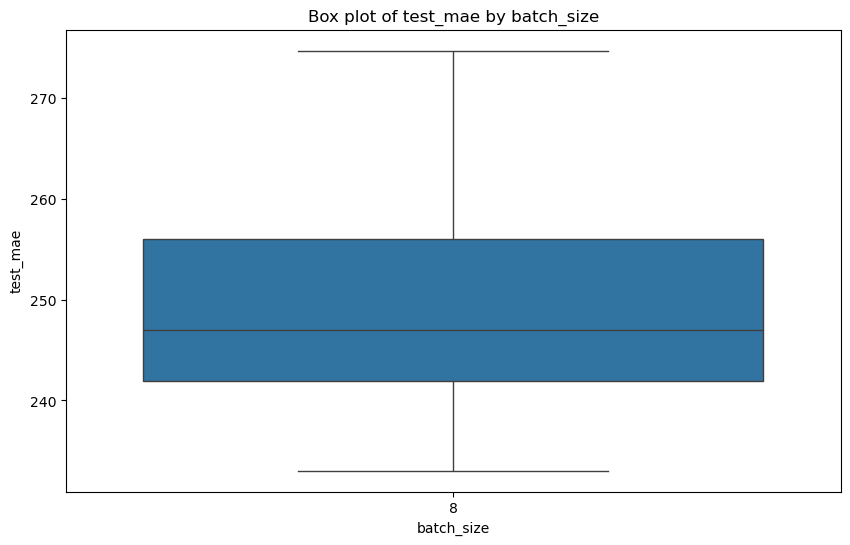

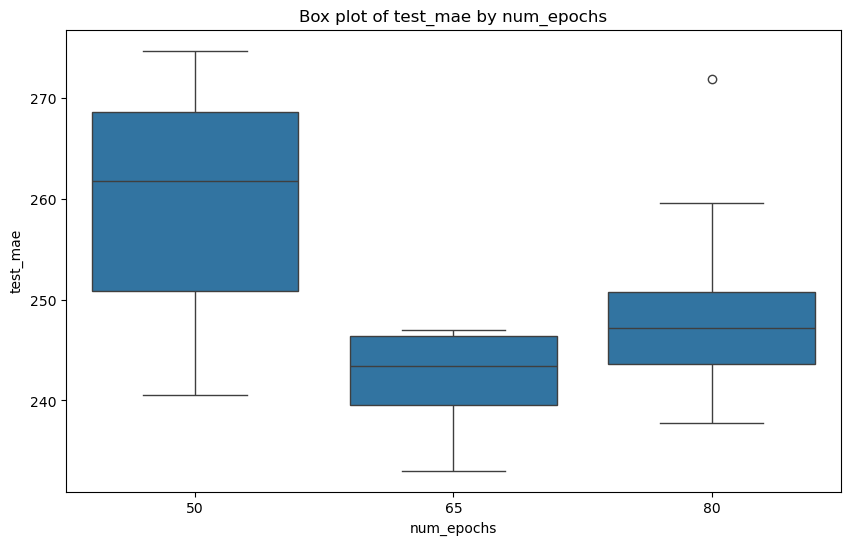

In [22]:
for df in dfs_1d:
    for feature in features_of_interest:
        create_box_plot(df, feature=feature, target='test_mae')

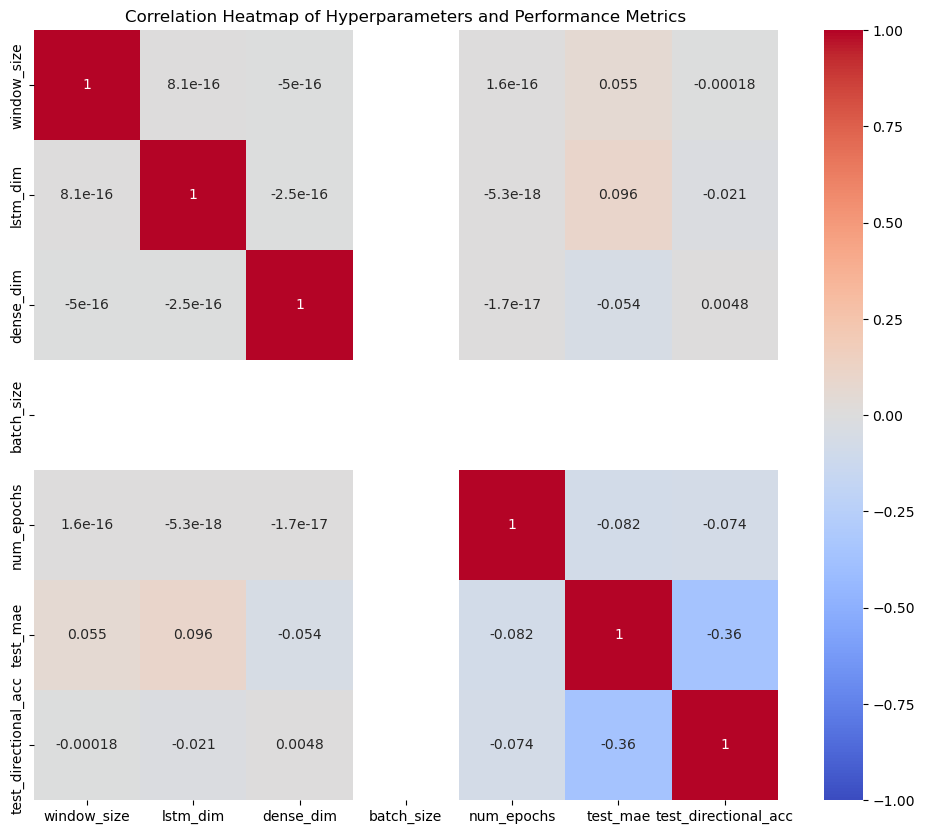

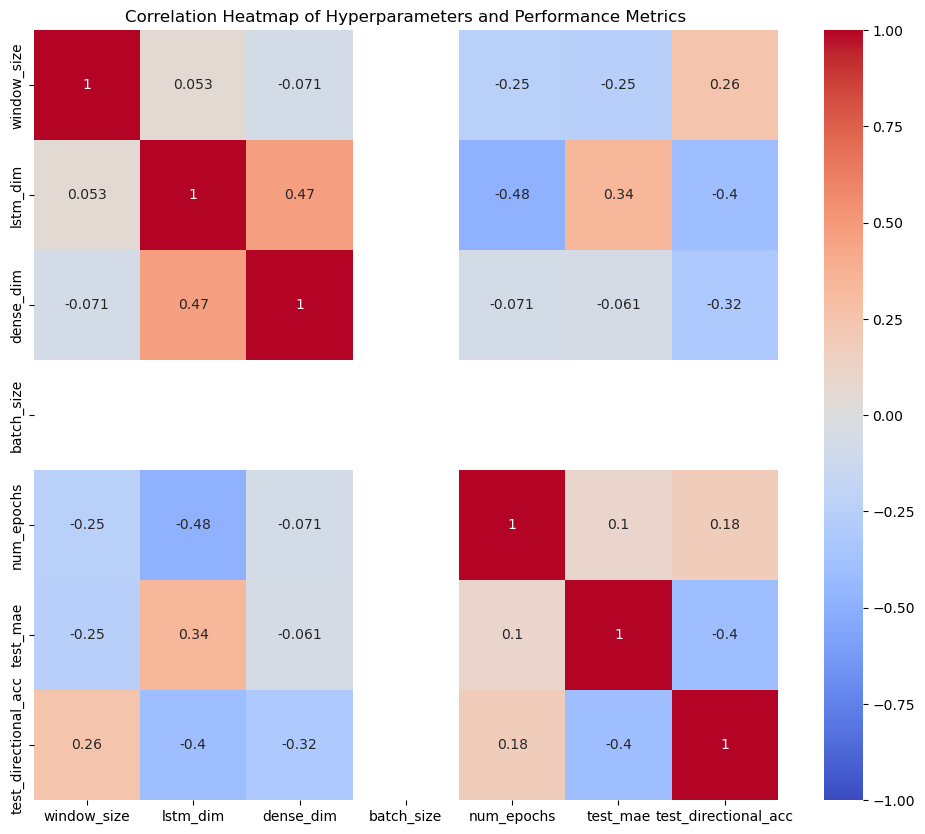

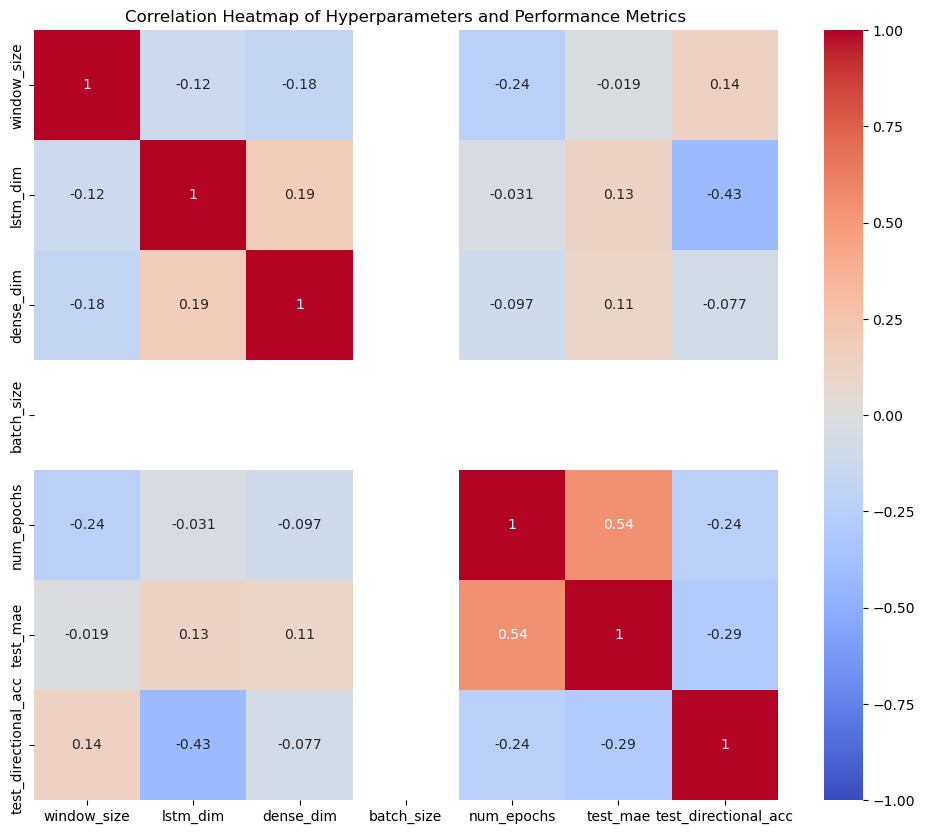

In [17]:
def correlation_heatmap(df, columns):
    corr = df[columns].corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Heatmap of Hyperparameters and Performance Metrics')
    plt.show()

correlation_heatmap(combined_30min, (features_of_interest + metrics_of_interest))
correlation_heatmap(df_30min_top10, (features_of_interest + metrics_of_interest))
correlation_heatmap(df_30min_top20, (features_of_interest + metrics_of_interest))

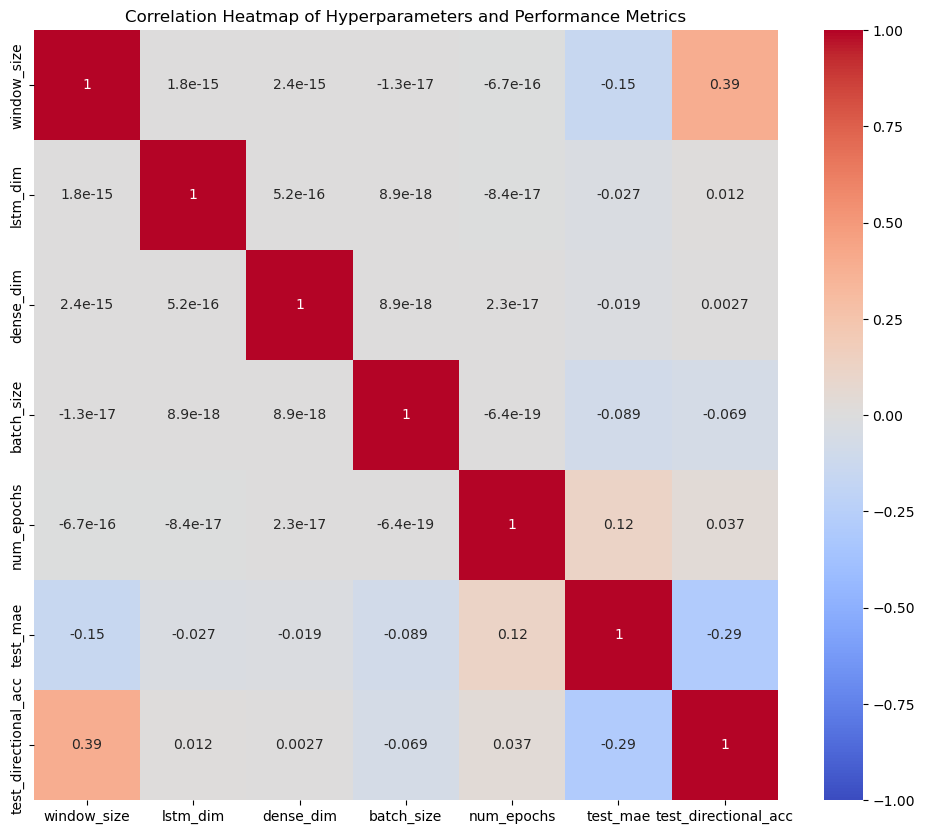

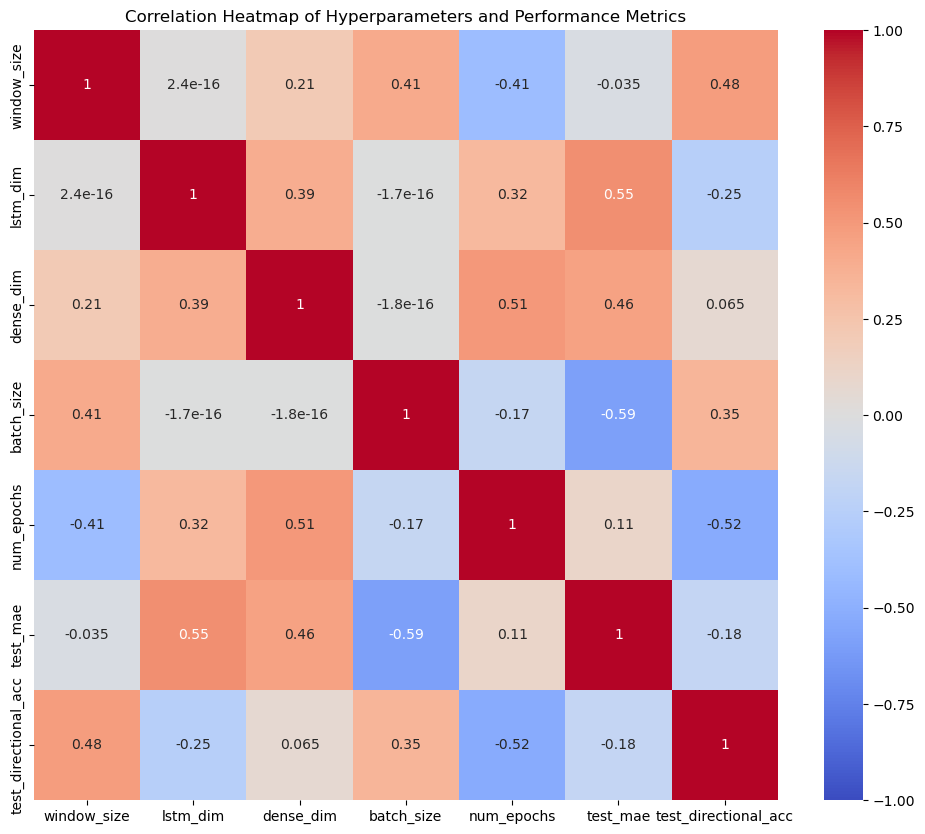

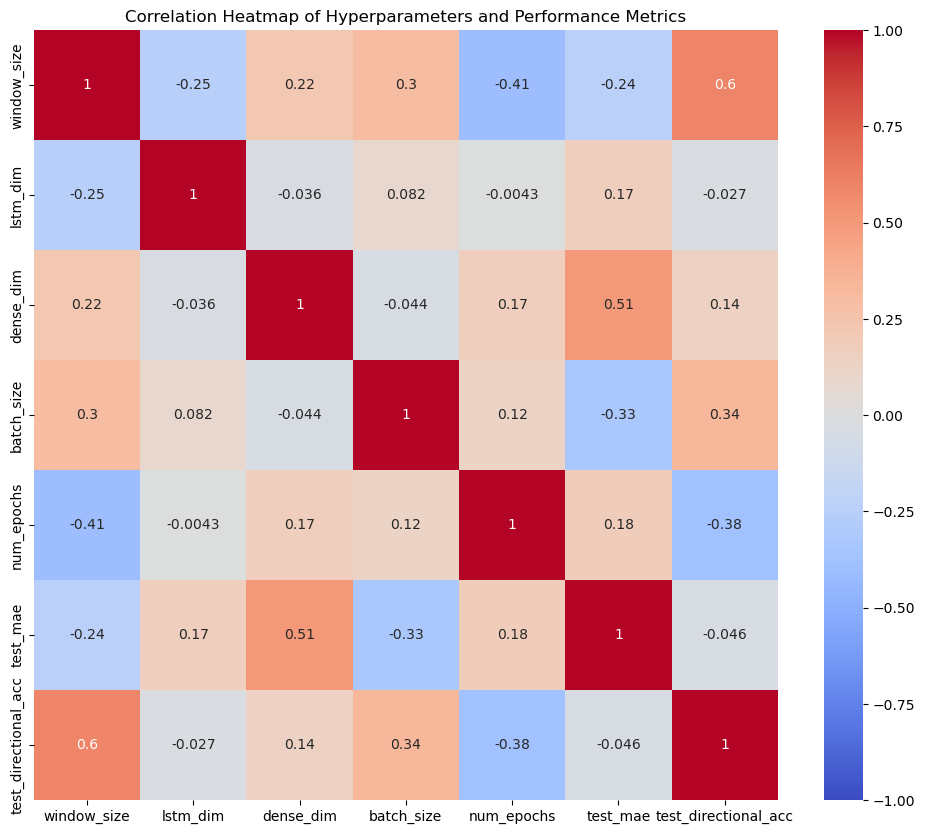

In [20]:
correlation_heatmap(combined_4h, (features_of_interest + metrics_of_interest))
correlation_heatmap(df_4h_top10, (features_of_interest + metrics_of_interest))
correlation_heatmap(df_4h_top20, (features_of_interest + metrics_of_interest))

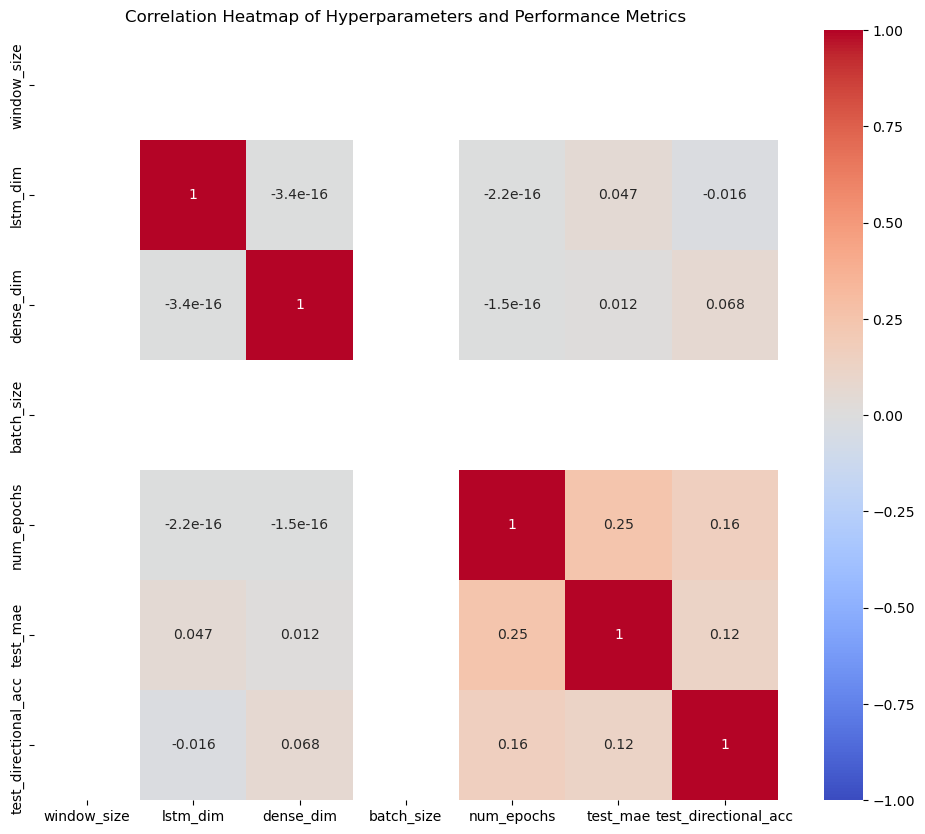

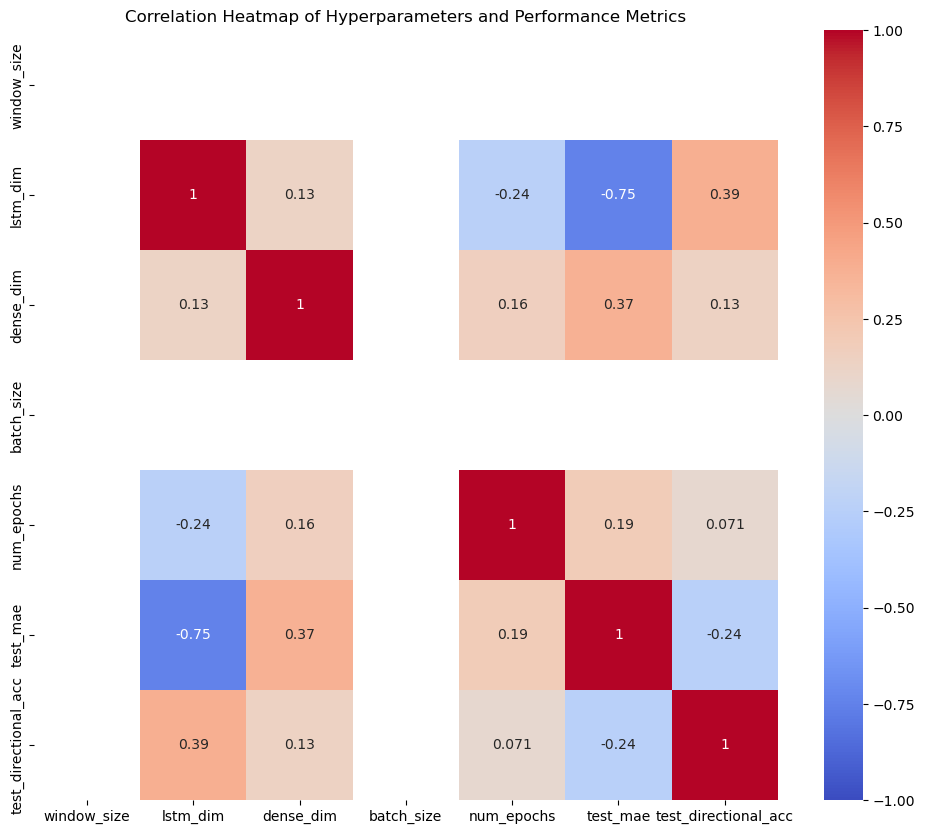

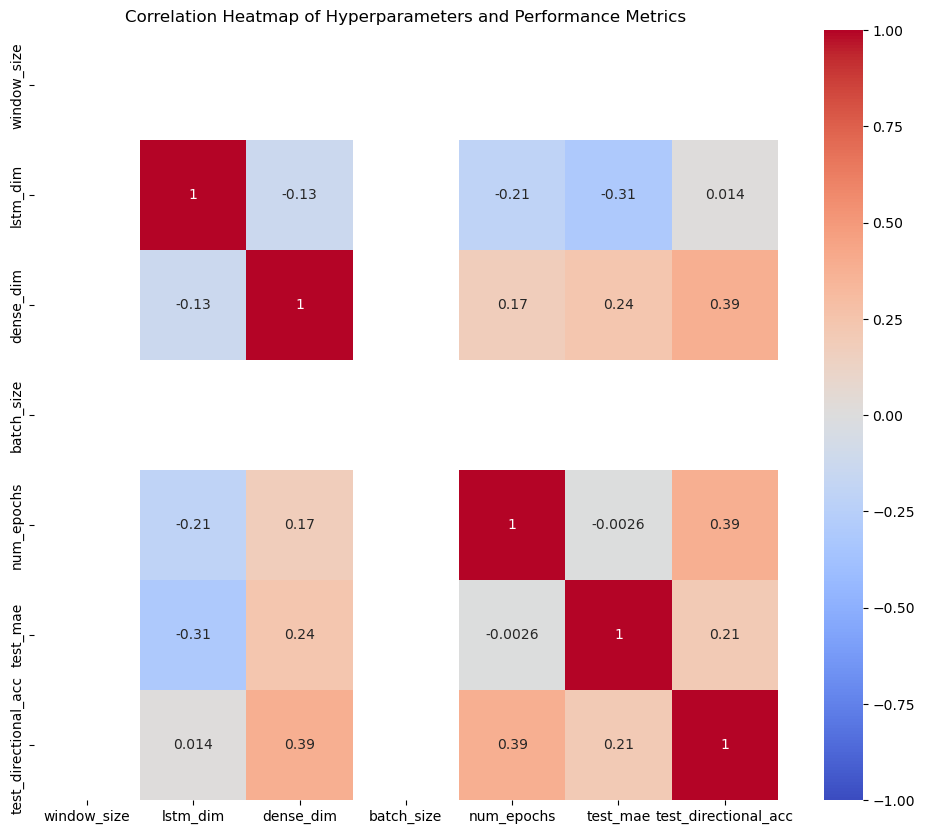

In [21]:
correlation_heatmap(combined_1d, (features_of_interest + metrics_of_interest))
correlation_heatmap(df_1d_top10, (features_of_interest + metrics_of_interest))
correlation_heatmap(df_1d_top20, (features_of_interest + metrics_of_interest))

In [79]:
def hyperparameter_importance(df, feature_columns, target_column):
    X = df[feature_columns]
    y = df[target_column]
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_scaled, y)
    
    importances = pd.DataFrame({
        'feature': feature_columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=importances)
    plt.title(f'Hyperparameter Importance for {target_column}')
    plt.show()

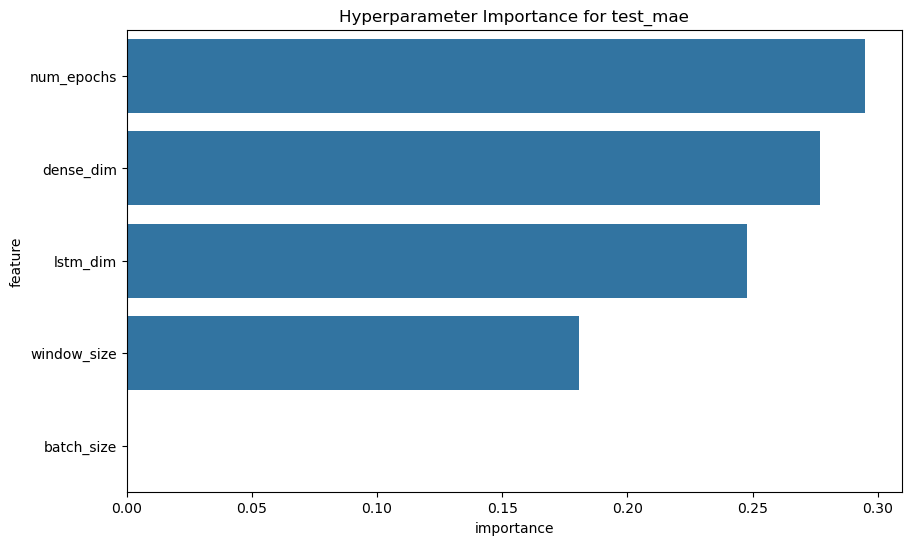

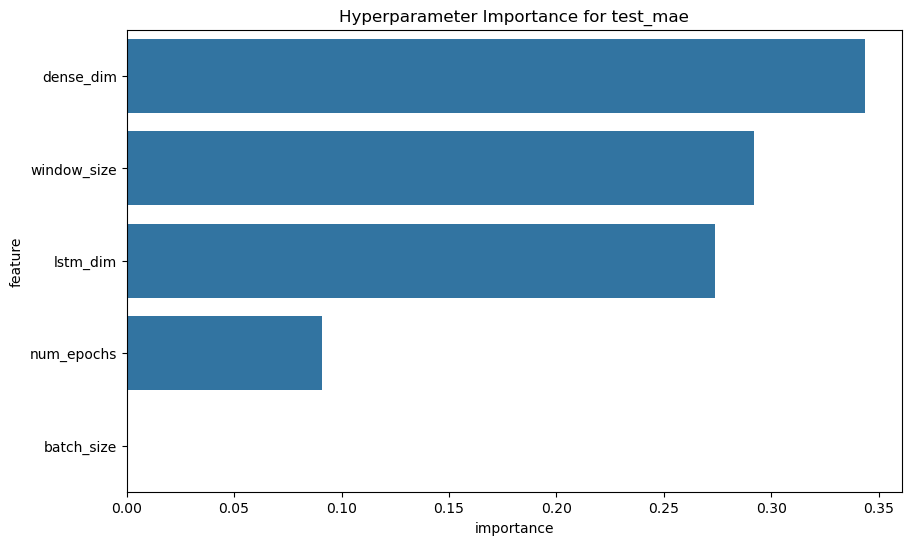

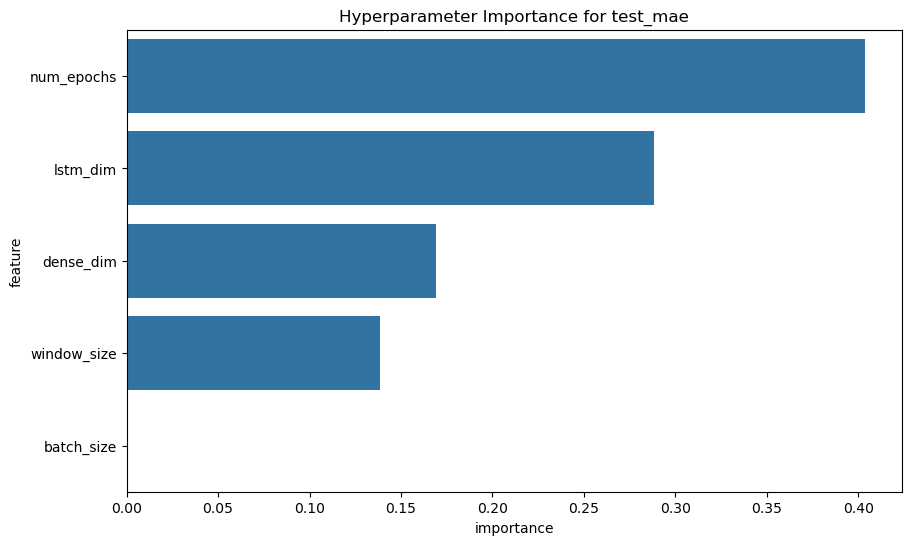

In [81]:
hyperparameter_importance(combined_30min, features_of_interest, 'test_mae')
hyperparameter_importance(df_30min_top10, features_of_interest, 'test_mae')
hyperparameter_importance(df_30min_top20, features_of_interest, 'test_mae')

# correlation_heatmap(combined_30min, (features_of_interest + metrics_of_interest))
# correlation_heatmap(df_30min_top10, (features_of_interest + metrics_of_interest))
# correlation_heatmap(df_30min_top20, (features_of_interest + metrics_of_interest))






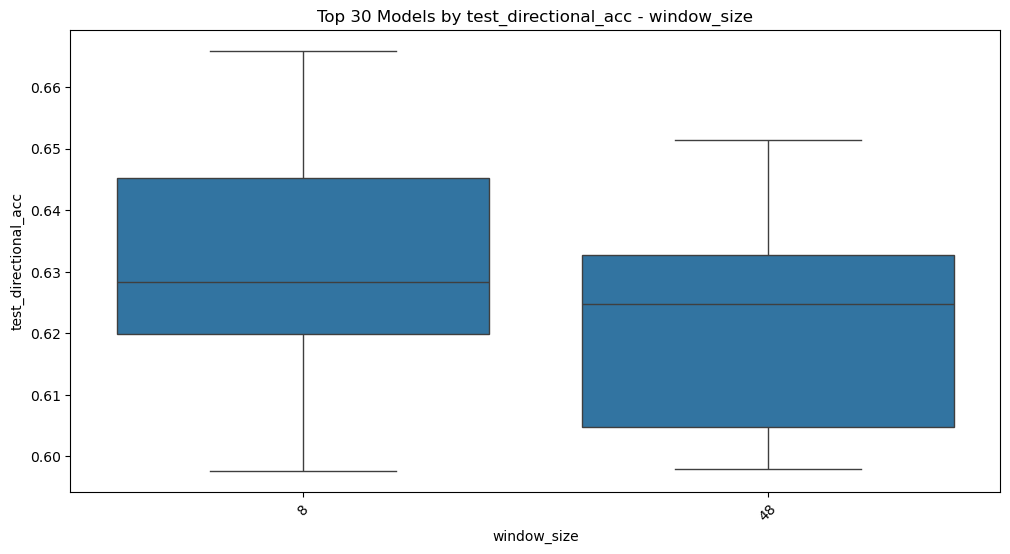

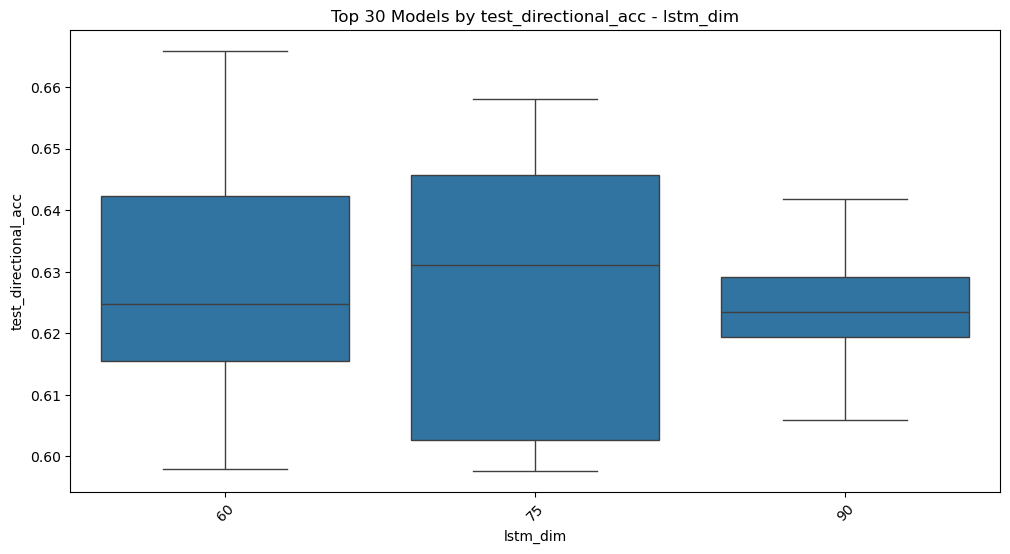

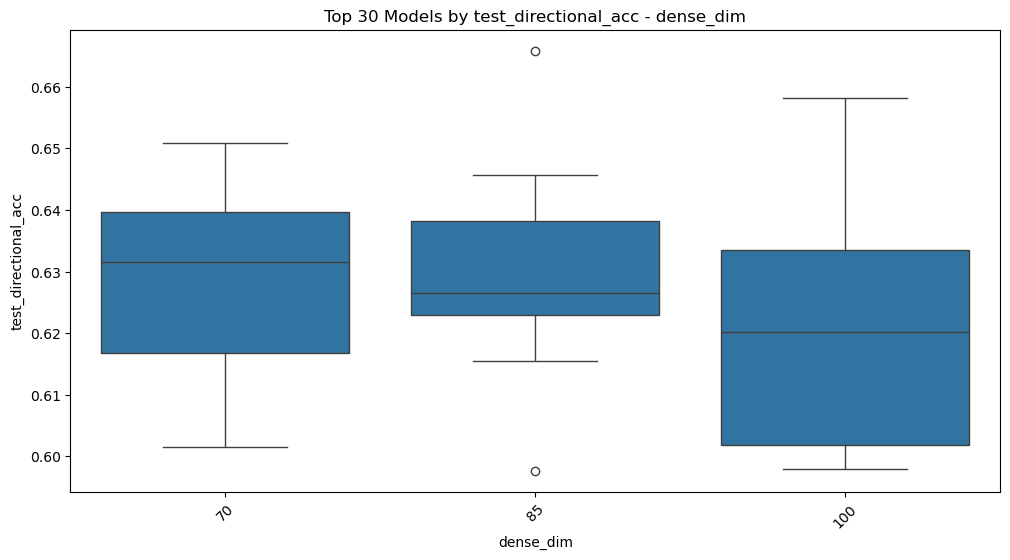

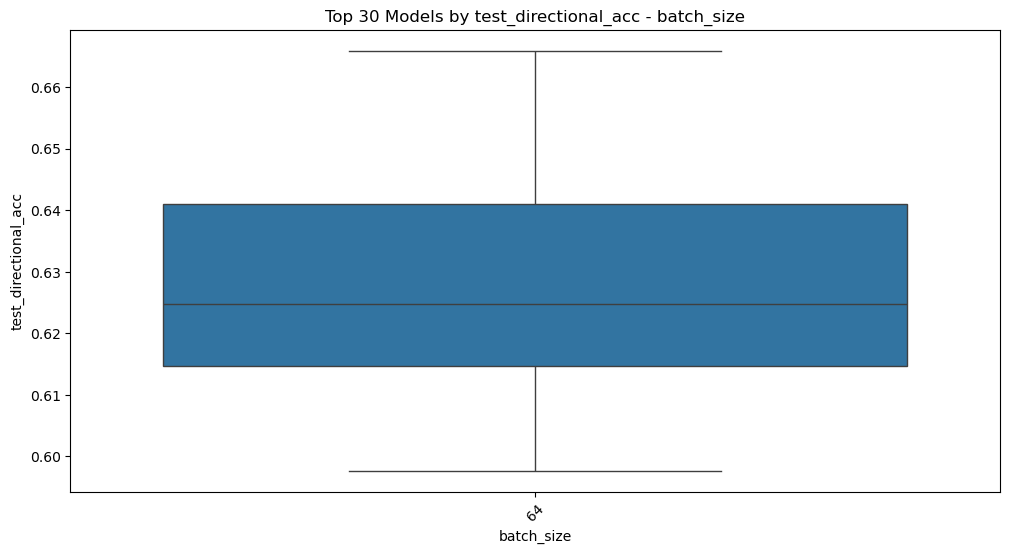

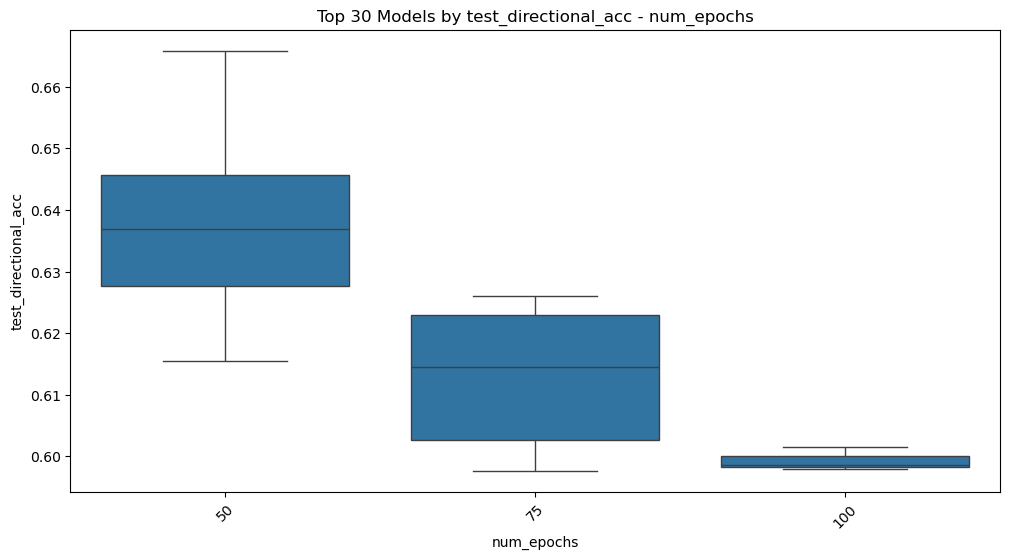

In [102]:
def plot_top_models_by_feature(df, target_feature, top_x=30):
    # Sort the DataFrame by the target feature
    sorted_df = df.nlargest(top_x, target_feature)
    
    for feature in features_of_interest:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=sorted_df[feature], y=sorted_df[target_feature])
        plt.title(f'Top {top_x} Models by {target_feature} - {feature}')
        plt.xticks(rotation=45)
        plt.xlabel(feature)
        plt.ylabel(target_feature)
        plt.show()

plot_top_models_by_feature(combined_30min, 'test_directional_acc')



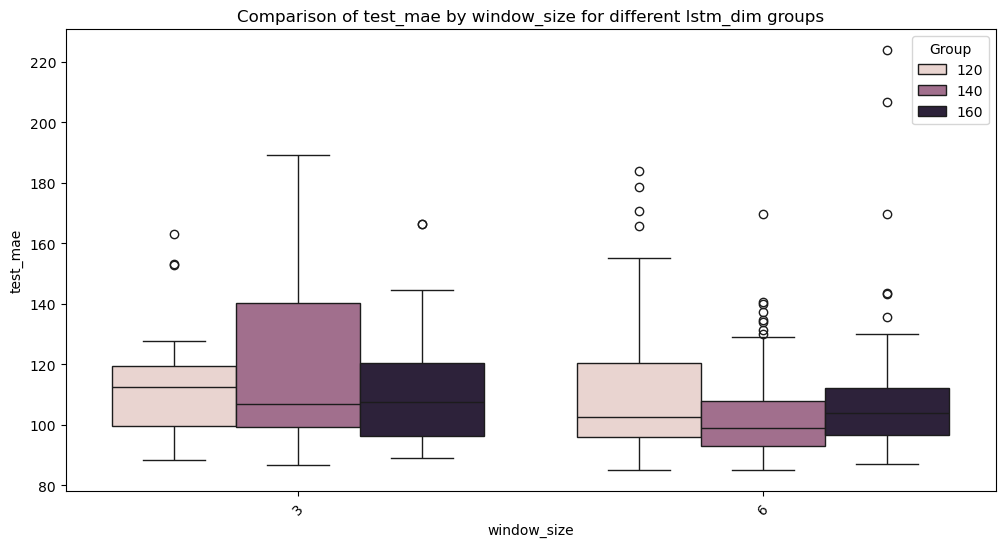

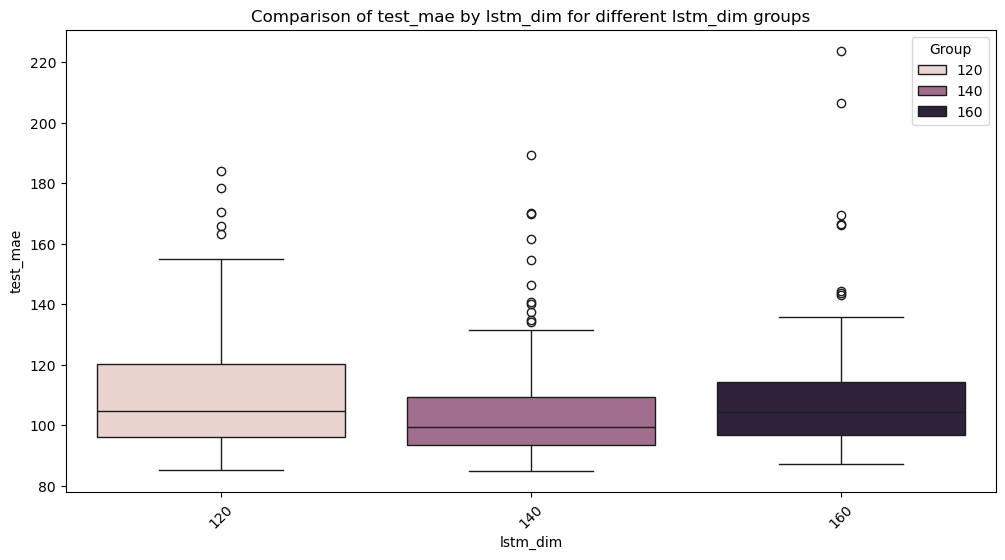

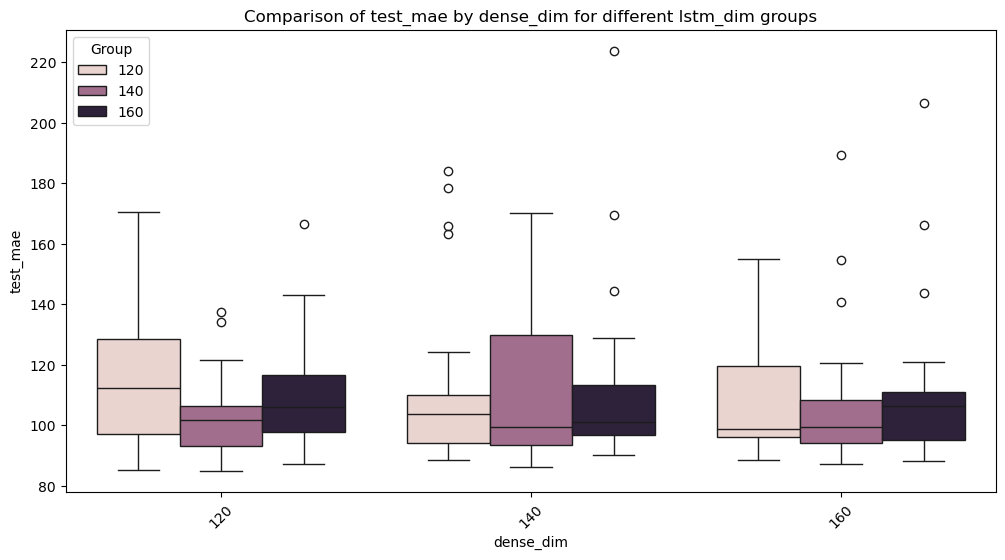

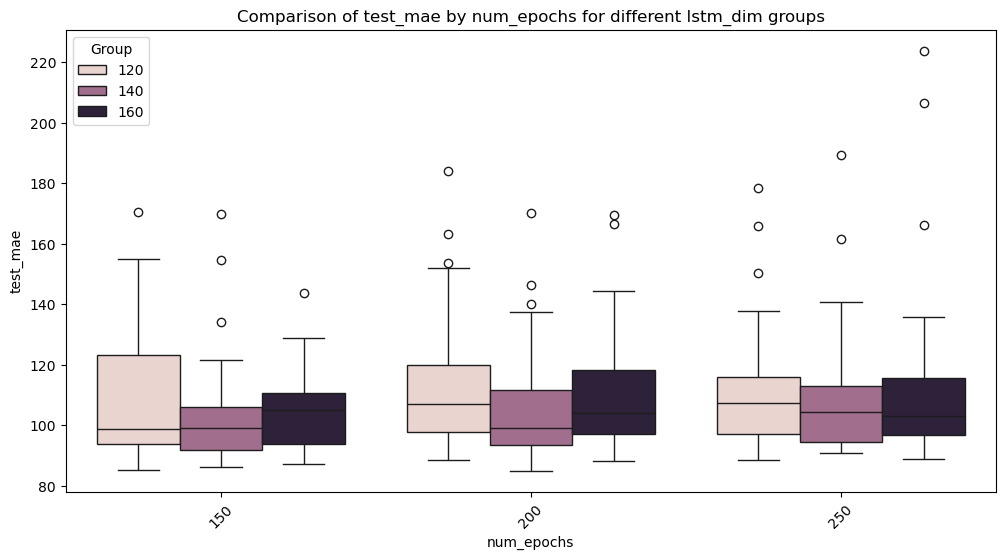

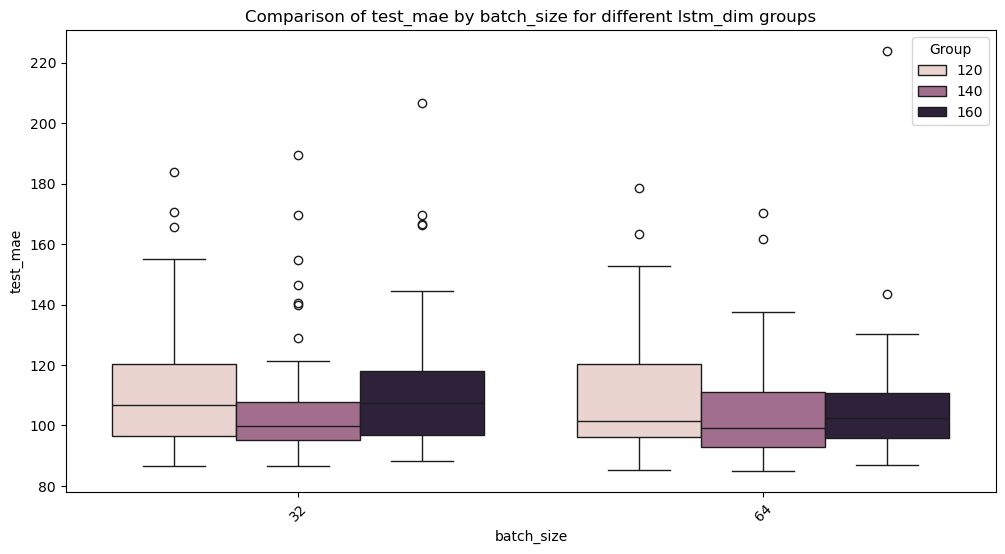

In [31]:
#from analysis1, grouped box plots to test:
feature_columns = [
    'window_size', 'lstm_dim', 'dense_dim', 'num_epochs', 'batch_size'
]

for feature in feature_columns:
    unique_values = combined_4h[feature].nunique()
    if unique_values > 1:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=feature, y='test_mae', hue='lstm_dim', data=combined_4h)
        plt.title(f'Comparison of test_mae by {feature} for different lstm_dim groups')
        plt.xlabel(feature)
        plt.ylabel('test_mae')
        plt.legend(title='Group')
        plt.xticks(rotation=45)
        plt.show()

In [35]:
df_30min_top20[metrics_of_interest]

,test_mae,test_directional_acc
3,29.063402,0.665861
48,29.139108,0.626461
7,29.159217,0.618843
30,29.162238,0.638235
12,29.179362,0.468476
24,29.191716,0.623410
0,29.201906,0.633172
1,29.203881,0.623589
24,29.208974,0.459610
21,29.218335,0.615529


In [36]:
df_4h_top20[metrics_of_interest]

,test_mae,test_directional_acc
21,84.858369,0.492086
1,85.149029,0.497122
25,86.013989,0.630935
19,86.269587,0.481295
0,86.418046,0.517266
20,86.662835,0.425700
37,86.979636,0.489928
33,87.146985,0.515108
18,87.983477,0.535252
104,88.091794,0.439568


In [41]:
df_1d_top20[metrics_of_interest].sort_values(by='test_directional_acc', ascending=True)


,test_mae,test_directional_acc
4,227.383043,0.424242
9,232.641318,0.432900
18,227.590132,0.432900
24,223.385657,0.437229
1,224.074158,0.437229
12,224.103142,0.437229
1,224.667305,0.437229
17,225.516712,0.437229
24,230.314683,0.441558
19,221.395200,0.441558


In [5]:
df_1d_top20.sort_values(by='test_directional_acc', ascending=True)

,window_size,lstm_dim,dense_dim,batch_size,num_epochs,train_mse,test_mse,train_mae,test_mae,train_rmse,...,test_r2,train_mape,test_mape,train_directional_acc,test_directional_acc,training_time,evaluation_time,time_frame,target,features
4,1,50,65,8,65,183350.244231,123380.619379,269.043397,227.383043,428.194167,...,0.982307,3.523797,2.026976,0.493003,0.424242,12.837027,0.002000,1d,close,price_plus_diffs
9,1,65,50,8,50,185923.436991,132884.710145,256.691876,232.641318,431.188401,...,0.980944,3.133076,2.049644,0.506997,0.432900,9.891809,0.002517,1d,close,price_plus_diffs
18,1,80,50,8,50,189676.088653,134086.250285,263.228634,227.590132,435.518184,...,0.980772,3.371318,2.000585,0.486545,0.432900,10.215846,0.002001,1d,close,price_only
24,1,80,80,8,50,188087.329690,126679.867684,256.313243,223.385657,433.690362,...,0.981834,3.173018,1.974356,0.491927,0.437229,10.151656,0.005507,1d,close,price_only
1,1,50,50,8,65,176222.725097,122707.651683,250.804149,224.074158,419.788905,...,0.982404,3.119341,1.987617,0.489774,0.437229,12.999965,0.002497,1d,close,price_plus_diffs
12,1,65,65,8,50,193216.789915,124081.216539,270.584654,224.103142,439.564318,...,0.982207,3.470681,1.990249,0.501615,0.437229,10.140027,0.001999,1d,close,price_only
1,1,50,50,8,65,187504.411228,125622.731847,253.623408,224.667305,433.017796,...,0.981986,3.092206,1.987928,0.499462,0.437229,12.986563,0.002000,1d,close,price_only
17,1,65,80,8,80,181706.787382,120816.871220,269.894398,225.516712,426.270791,...,0.982675,3.529319,2.012169,0.488698,0.437229,16.208570,0.001998,1d,close,price_plus_diffs
24,1,80,80,8,50,177504.086979,124526.894784,251.542994,230.314683,421.312339,...,0.982143,3.144384,2.038968,0.498385,0.441558,9.951514,0.004506,1d,close,price_plus_diffs
19,1,80,50,8,65,190692.478023,122786.275256,265.782014,221.395200,436.683499,...,0.982393,3.387992,1.962668,0.496233,0.441558,13.372417,0.002000,1d,close,price_only


In [46]:
df_4h_top20.sort_values(by='test_directional_acc', ascending=False)


,window_size,lstm_dim,dense_dim,batch_size,num_epochs,train_mse,test_mse,train_mae,test_mae,train_rmse,...,test_r2,train_mape,test_mape,train_directional_acc,test_directional_acc,training_time,evaluation_time,time_frame,target,features
25,6,140,140,64,150,30657.289317,19263.194764,93.628199,86.013989,175.092231,...,-0.121875,inf,inf,0.625090,0.630935,29.248481,0.162144,4h,close_diff,price_plus_diffs
51,6,160,160,64,200,30219.222931,21065.576349,94.214144,89.461020,173.836771,...,-0.226844,inf,inf,0.610394,0.598561,38.055128,0.041034,4h,close_diff,price_plus_diffs
24,6,140,140,32,150,32132.987743,21442.804403,100.442048,90.030656,179.256765,...,-0.248814,inf,inf,0.550000,0.556115,54.819046,0.201648,4h,close_diff,price_only
18,6,140,120,32,150,31400.170925,20425.152854,93.443617,87.983477,177.200934,...,-0.189546,inf,inf,0.547670,0.535252,54.252460,0.255959,4h,close_diff,price_only
0,6,120,120,32,150,31748.978674,19522.913101,96.195534,86.418046,178.182431,...,-0.137001,inf,inf,0.530645,0.517266,50.169664,0.027027,4h,close_diff,price_only
33,6,140,160,64,200,31819.757819,19886.145244,96.426775,87.146985,178.380935,...,-0.158155,inf,inf,0.511828,0.515108,39.087068,0.115077,4h,close_diff,price_only
6,6,120,140,32,150,31615.684806,19911.722432,95.758854,88.795272,177.808000,...,-0.159645,inf,inf,0.524014,0.512950,50.247735,0.018506,4h,close_diff,price_only
9,6,120,140,64,200,31321.769629,20292.077127,92.382640,88.618266,176.979574,...,-0.181796,inf,inf,0.496057,0.508633,37.080509,0.023017,4h,close_diff,price_only
11,6,120,140,64,250,31486.559720,20506.836004,94.391354,88.542337,177.444526,...,-0.194303,inf,inf,0.501075,0.506475,47.599513,0.029047,4h,close_diff,price_only
13,6,120,160,64,150,33114.341872,19784.949337,105.554203,88.678486,181.973465,...,-0.152261,inf,inf,0.470609,0.502158,28.242607,0.022522,4h,close_diff,price_only


In [49]:
df_30min_top20.sort_values(by='test_directional_acc', ascending=False)


,window_size,lstm_dim,dense_dim,batch_size,num_epochs,train_mse,test_mse,train_mae,test_mae,train_rmse,...,test_r2,train_mape,test_mape,train_directional_acc,test_directional_acc,training_time,evaluation_time,time_frame,target,features
3,8,60,85,64,50,5011.982893,2448.296019,33.855797,29.063402,70.795359,...,-0.000436,inf,inf,0.663713,0.665861,76.929857,0.092078,30min,close_diff,price_plus_diffs
6,8,60,100,64,50,5056.509029,2476.850055,35.008280,29.310882,71.109135,...,-0.012104,inf,inf,0.652189,0.643650,76.735873,0.184651,30min,close_diff,price_plus_diffs
30,48,60,85,64,50,5028.959387,2445.632192,34.060171,29.162238,70.915156,...,0.000670,inf,inf,0.656446,0.638235,72.952381,0.292531,30min,close_diff,price_plus_diffs
0,8,60,70,64,50,5021.337957,2457.548639,34.150861,29.201906,70.861400,...,-0.004217,inf,inf,0.658969,0.633172,77.266800,0.085084,30min,close_diff,price_plus_diffs
48,48,90,85,64,50,5013.114198,2460.701770,33.858802,29.139108,70.803349,...,-0.005488,inf,inf,0.652325,0.626461,73.762910,4.225480,30min,close_diff,price_plus_diffs
31,48,60,85,64,75,5007.057761,2496.488508,34.003607,29.332377,70.760566,...,-0.020111,inf,inf,0.640208,0.626011,110.493849,0.294525,30min,close_diff,price_plus_diffs
1,8,60,70,64,75,5007.724930,2469.474907,33.844880,29.203881,70.765281,...,-0.009090,inf,inf,0.643887,0.623589,115.588282,0.190652,30min,close_diff,price_plus_diffs
24,8,90,100,64,50,5029.109551,2462.552642,34.354864,29.191716,70.916215,...,-0.006262,inf,inf,0.635450,0.623410,73.112969,0.130522,30min,close_diff,price_plus_diffs
7,8,60,100,64,75,5010.403970,2457.673631,33.943868,29.159217,70.784207,...,-0.004268,inf,inf,0.635047,0.618843,114.386488,0.051565,30min,close_diff,price_plus_diffs
21,8,90,85,64,50,5025.619430,2449.771221,34.067578,29.218335,70.891603,...,-0.001039,inf,inf,0.639411,0.615529,74.806529,0.132509,30min,close_diff,price_plus_diffs


In [51]:
combined_df.columns

Index(['window_size', 'lstm_dim', 'dense_dim', 'batch_size', 'num_epochs',
       'train_mse', 'test_mse', 'train_mae', 'test_mae', 'train_rmse',
       'test_rmse', 'train_r2', 'test_r2', 'train_mape', 'test_mape',
       'train_directional_acc', 'test_directional_acc', 'training_time',
       'evaluation_time', 'time_frame', 'target', 'features'],
      dtype='object')

In [10]:
metrics = ['test_mse', 'test_mae', 'test_rmse', 'test_r2', 'test_mape', 'test_directional_acc', 'training_time', 'evaluation_time']

In [32]:
daily_top_5 = df_1d_top20.sort_values(by='test_directional_acc', ascending=True).head(5)
top_5_4h = df_4h_top20.sort_values(by='test_directional_acc', ascending=False).head(5)
top_5_30min = df_30min_top20.sort_values(by='test_directional_acc', ascending=False).head(5)

In [33]:
daily_top_5_avg = daily_top_5[metrics].mean()
top_5_4h_avg = top_5_4h[metrics].mean()
top_5_30min_avg = top_5_30min[metrics].mean()

In [34]:
daily_top_5_avg

test_mse                127947.819835
test_mae                   227.014862
test_rmse                  357.636979
test_r2                      0.981652
test_mape                    2.007835
test_directional_acc         0.432900
training_time               11.219261
evaluation_time              0.002904
dtype: float64

In [35]:
top_5_4h_avg

test_mse                2.034393e+04
test_mae                8.798144e+01
test_rmse               1.426013e+02
test_r2                -1.848159e-01
test_mape                        inf
test_directional_acc    5.676259e-01
training_time           4.530896e+01
evaluation_time         1.375624e-01
dtype: float64

In [36]:
top_5_30min_avg

test_mse                2457.805735
test_mae                  29.175507
test_rmse                 49.576137
test_r2                   -0.004315
test_mape                       inf
test_directional_acc       0.641476
training_time             75.529564
evaluation_time            0.975965
dtype: float64

In [31]:
top_5_4h[metrics]

,test_mse,test_mae,test_rmse,test_r2,test_mape,test_directional_acc,training_time,evaluation_time
25,19263.194764,86.013989,138.791912,-0.121875,inf,0.630935,29.248481,0.162144
51,21065.576349,89.461020,145.139851,-0.226844,inf,0.598561,38.055128,0.041034
24,21442.804403,90.030656,146.433618,-0.248814,inf,0.556115,54.819046,0.201648
18,20425.152854,87.983477,142.916594,-0.189546,inf,0.535252,54.252460,0.255959
0,19522.913101,86.418046,139.724418,-0.137001,inf,0.517266,50.169664,0.027027


In [30]:
top_5_30min[metrics]

,test_mse,test_mae,test_rmse,test_r2,test_mape,test_directional_acc,training_time,evaluation_time
3,2448.296019,29.063402,49.480259,-0.000436,inf,0.665861,76.929857,0.092078
6,2476.850055,29.310882,49.767962,-0.012104,inf,0.643650,76.735873,0.184651
30,2445.632192,29.162238,49.453333,0.000670,inf,0.638235,72.952381,0.292531
0,2457.548639,29.201906,49.573669,-0.004217,inf,0.633172,77.266800,0.085084
48,2460.701770,29.139108,49.605461,-0.005488,inf,0.626461,73.762910,4.225480


In [39]:
pd.set_option('display.float_format', '{:.6f}'.format)  # Set the float display format for clarity
print(top_5_4h_avg)
print(top_5_30min_avg)
print(daily_top_5_avg)

test_mse               20343.928294
test_mae                  87.981438
test_rmse                142.601279
test_r2                   -0.184816
test_mape                       inf
test_directional_acc       0.567626
training_time             45.308956
evaluation_time            0.137562
dtype: float64
test_mse               2457.805735
test_mae                 29.175507
test_rmse                49.576137
test_r2                  -0.004315
test_mape                      inf
test_directional_acc      0.641476
training_time            75.529564
evaluation_time           0.975965
dtype: float64
test_mse               127947.819835
test_mae                  227.014862
test_rmse                 357.636979
test_r2                     0.981652
test_mape                   2.007835
test_directional_acc        0.432900
training_time              11.219261
evaluation_time             0.002904
dtype: float64
